In [1]:
%pylab inline

from __future__ import division

import os
import copy
import argparse
import fnmatch
import numpy as np

import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
# AstroML
from astroML.plotting import hist

# Matplotlib related
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

# Personal
import hscUtils as hUtil
import galSBP

import cPickle as pickle

amag_sun_g = 5.33
amag_sun_r = 4.67
amag_sun_i = 4.48
amag_sun_z = 4.42

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Location of the cutouts 

""" On Astro3 / For MacOS"""
baseDir = '/Users/songhuang/astro3/hscs' 
redBCG = os.path.join(baseDir, 'redmapper')
nonBCG = os.path.join(baseDir, 'nonbcg')

# A Few Useful Functions

In [2]:
def normProfile(rad, sbp, minRad, maxRad): 
    """
    Normalize the profile 
    """
    offset = np.nanmedian(sbp[(rad >= minRad) & (rad <= maxRad)])
    
    return (sbp-offset)

In [3]:
def logAdd(para1, para2):    
    """
    Doc
    """
    return np.log10((10.0 ** np.asarray(para1)) + (10.0 ** np.asarray(para2)))

In [4]:
def loadGalfitOutput(pklFile):     
    """
    Load a .pkl file for GALFIT model 
    Return the GalfitParser object 
    """
    if not os.path.isfile(pklFile): 
        raise Exception("XXX Can not find the .pkl file : %s") % pklFile 
    else: 
        return pickle.load(open(pklFile, 'rb'))

In [5]:
def findProfile(pattern, loc, verbose=False):
    """
    Find the prefix of the ellipse profiles 
    """
    result = []
    for root, dirs, files in os.walk(loc):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
                
    if verbose: 
        print "### %d files found !" % len(result)
    
    return result

In [6]:
def readProfile(ellFile):
    """
    Load the pickle format 1-D profile
    """
    if os.path.isfile(ellFile):
        return pickle.load(open(ellFile, 'rb'))
    else:
        raise Exception("XXX Can not find the Ellipse file")

In [7]:
def getEllipProfile(objid, loc, stage='3', verbose=False):
    
    pattern = '*' + str(objid) + '*_img_ellip_' + stage + '.pkl'
    
    result = findProfile(pattern, loc)
    
    if len(result) == 0: 
        #raise Exception('XXX Can not find the Ellipse profile ! %s' % pattern)
        if verbose:
            print 'XXX Can not find the Ellipse profile ! %s' % pattern
            return None
    elif len(result) == 1: 
        ellProf = readProfile(result[0])
        return ellProf
    else: 
        if verbose:
            print "XXX Warning: More than 1 profiles found! Use the first one : %s" % result[0]
        ellProf = readProfile(result[0])
        return ellProf 

In [8]:
def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    The corresponding Kpc size of a pixel 
    """
    
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)
    
    if show:
        print "# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc)
        
    return pixKpc

In [9]:
def correctProf(ellProf, redshift, verbose=False, extinction=0.0, zp=27.0, 
                amag_sun=None, corCurve=False):
    
    """
    DOC
    """
    
    scale = hUtil.cosmoScale(redshift)
    distmod = hUtil.cosmoDistMod(redshift)
    
    if verbose: 
        print "### REDSHIFT : %6.4f" % redshift
        print "### SCALE : %7.4f kpc/arcsec" % scale 
        print "### DISTMOD : %7.4f mag" % distmod
    
    sma_kpc = ellProf['sma_asec'] * scale
    if not corCurve:
        abs_mag = -2.5 * np.log10(ellProf['growth_ori']) + zp - extinction - distmod
    else:
        abs_mag = -2.5 * np.log10(ellProf['growth_cor']) + zp - extinction - distmod

    if amag_sun is not None: 
        abs_sbp = (amag_sun + 21.572 - (ellProf['sbp'] - extinction))/2.5 + 6.0
    else:
        abs_sbp = ellProf['sbp'] - extinction

    return sma_kpc, abs_sbp, abs_mag

In [10]:
def photoCompare(sample, zp=27.0, prefix='hsc_xmm_log11.6', amag_sun=amag_sun_i, 
                 pix=0.168, absMag=True, aStr='extinction_i', verbose=False,
                 magStr='cModelAbsMag_i', stage='3', plot=True, color='b', 
                 radius=None, corCurve=False, idStr='objid_dr12', 
                 massStr='logMass', zStr='z', extCorrect=True, ax=None, 
                 marker='o'):
    
    """
    DOC
    """
    
    """ Read in the sample catalog """
    catFile = prefix + '_' + sample + '.fits' 
    catData = fits.open(catFile)[1].data
    
    """ Useful columns """
    gal_id   = catData[idStr]
    gal_z    = catData[zStr]
    
    if extCorrect:
        gal_alam = catData[aStr]
    else: 
        gal_alam = gal_z * 0.0
        
    gal_mag  = catData[magStr]
    gal_logm = catData[massStr]

    """ The "total" magnitude from SBP """
    mag_sbp = [] 
    mag_sdss = []
    
    for ii in range(len(catData)): 
        
        """ Get the Ellipse profile """
        ellProf = getEllipProfile(gal_id[ii], sample, stage=stage)
        
        if ellProf is not None:
            
            """ Get the radius in Kpc, luminosity profile, and growth curve for absolute magnitude """
            sma_kpc, abs_sbp, abs_cog = correctProf(ellProf, gal_z[ii], extinction=gal_alam[ii], 
                                                    zp=27.0, amag_sun=amag_sun, corCurve=corCurve)
            
            """ Distance module """
            distmod = hUtil.cosmoDistMod(gal_z[ii])
            
            if radius is None: 
                mag_use = ellProf['mag_tot'][0] - gal_alam[ii]
                if absMag:
                    mag_use = mag_use - distmod
            else: 
                rsma_use = radius ** 0.25
                rsma_common = np.arange(0, 4.5, 0.1)
                
                indexUse = np.isfinite(abs_cog)
                intrpFunc = interp1d(sma_kpc[indexUse]**0.25, abs_cog[indexUse], kind='linear')
                try:
                    mag_use = intrpFunc(rsma_use) - gal_alam[ii]
                    if not absMag:
                        mag_use = mag_use + distmod
                except Exception:
                    print "### Interpolation range is bad : %d" % gal_id[ii]
                    mag_use = ellProf['mag_tot'][0] - gal_alam[ii]
                    if absMag:
                        mag_use = mag_use - distmod
                
            mag_sbp.append(mag_use) 
            mag_sdss.append(gal_mag[ii])
            
            if verbose:
                print "### %22d -- %6.3f -- %6.3f -- %6.3f" % (gal_id[ii], gal_mag[ii], 
                                                               ellProf['mag_tot'][0], distmod)
    mag_sbp = np.asarray(mag_sbp)
    mag_sdss = np.asarray(mag_sdss)
    
    if plot:
        if ax is not None: 
            ax.scatter(mag_sbp, mag_sdss, marker=marker, color=color)
        else:
            scatter(mag_sbp, mag_sdss, marker=marker, color=color)
        
    return mag_sbp

In [33]:
def getStackProfile(sample, zp=27.0, prefix='hsc_xmm_log11.6', amag_sun=amag_sun_i, 
                    pix=0.168, absMag=True, aStr='extinction_i', verbose=False,
                    magStr='cModelAbsMag_i', stage='3', plot=True, plotAvg=True, 
                    color='b', width=0.9, singleColor='k', 
                    radius=None, corCurve=False, useMedian=True, alpha=0.1,
                    minRsma=0.3, maxRsma=3.5, extCorrect=True, idStr='objid_dr12', 
                    zStr='z', massStr='logMass', rsmaStep=0.1, ax=None, root=None, 
                    idSuffix=None, dirSuffix=None, catFile=None):
    
    """
    DOC
    """
    
    """ Read in the sample catalog """
    if catFile is None:
        catFile = prefix + '_' + sample + '.fits' 
        
    if root is not None: 
        catFile = os.path.join(root, catFile)
        
    if not os.path.isfile(catFile):
        raise Exception('XXX Can not find the input catalog : %s', catFile)
    else:
        catData = fits.open(catFile)[1].data
    
    """ Useful columns """
    gal_id   = catData[idStr]
    gal_z    = catData[zStr]
    print "### Median Redshift : %5.3f" % np.nanmedian(gal_z)
    
    if extCorrect:
        try:
            gal_alam = catData[aStr]
        except Exception: 
            print "### Can not find the column : %s" % aStr 
            gal_alam = gal_z * 0.0
    else:
        gal_alam = gal_z * 0.0
    
    if magStr is not None:
        try:
            gal_mag = catData[magStr]
            print " ## Median Magnitude : %5.2f" % np.nanmedian(gal_mag)
        except Exception:
            print "### Can not find the column : %s" % magStr 
            gal_mag = gal_z * 0.0
    else: 
        gal_mag = gal_z * 0.0 
        
    if massStr is not None:
        try:
            gal_mass = catData[massStr]
            print " ## Median Log Stellar Mass : %5.2f" % np.nanmedian(gal_mass)
        except Exception: 
            print "### Can not find the column : %s" % massStr 
            gal_mass = gal_z * 0.0            
    else: 
        gal_mass = gal_z * 0.0
    
    """ Plot """
    for ii in range(len(catData)): 
        
        if root is not None: 
            profDir = os.path.join(root, sample)
        else: 
            profDir = sample 
            
        if idSuffix is None: 
            pattern = str(gal_id[ii])
        else: 
            pattern = str(gal_id[ii]) + '*' + idSuffix 
            
        if dirSuffix is None: 
            location = profDir
        else: 
            location = profDir + '_' + dirSuffix
            
        ellProf = getEllipProfile(pattern, location, stage=stage)
    
        if ellProf is not None:
            sma_kpc, abs_sbp, abs_cog = correctProf(ellProf, gal_z[ii], 
                                                    extinction=gal_alam[ii], 
                                                    zp=27.0, verbose=False, 
                                                    amag_sun=amag_sun, 
                                                    corCurve=corCurve)
                    
            if plot:
                if ax is not None:
                    ax.plot(sma_kpc**0.25, abs_sbp, singleColor, alpha=alpha, linewidth=width)
                else: 
                    plot(sma_kpc**0.25, abs_sbp, singleColor, alpha=alpha, linewidth=width)  
                        
            intrpFunc = interp1d(sma_kpc**0.25, abs_sbp, 
                                 kind='linear')
            try:
                rsma_common = np.arange(minRsma, maxRsma, rsmaStep)
                asbp_intrp = intrpFunc(rsma_common)
                
                try: 
                    asbp_stack = np.vstack((asbp_stack, asbp_intrp))
                except NameError: 
                    asbp_stack = asbp_intrp
                        
            except Exception as errMsg:
                print errMsg
                print "### Bad interpolation range: %d " % gal_id[ii]
                print "    %5.2f -- %5.2f" % (np.nanmin(sma_kpc**0.25), 
                                              np.nanmax(sma_kpc**0.25))
    
    if useMedian:
        asbp_avg = np.nanmedian(asbp_stack, axis=0) 
    else:
        asbp_avg = np.nanmean(asbp_stack, axis=0) 

    if plotAvg:
        if ax is not None:
            print len(rsma_common)
            print len(asbp_avg)
            ax.plot(rsma_common, asbp_avg, color, linewidth=3.5)
        else:
            plot(rsma_common, asbp_avg, color, linewidth=3.5)
    
    return rsma_common, asbp_avg, asbp_stack

# Playground

### Z1
### Z2
### Z3

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10



### Z4


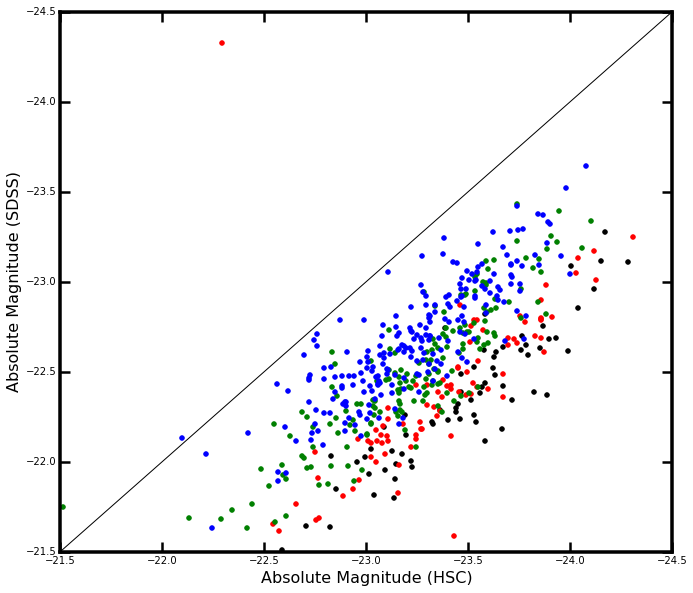

In [38]:
#def photoCompare(sample, zp=27.0, prefix='hsc_xmm_log11.6', amag_sun=amag_sun_i, 
#                 pix=0.168, absMag=True, aStr='extinction_i', verbose=False,
#                 magStr='cModelAbsMag_i', stage='3', plot=True, color='b', 
#                 radius=None, corCurve=False, idStr='objid_dr12', 
#                 massStr='logMass', zStr='z', extCorrect=True, ax=None, 
#                 marker='o'):

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

maxR = 100.0

print "### Z1"
mag_sbp_z1 = photoCompare('z1', color='k', radius=maxR, ax=ax1)
print "### Z2"
mag_sbp_z2 = photoCompare('z2', color='r', radius=maxR, ax=ax1)
#mag_sbp_z2_b = photoCompare('z2', color='b', radius=100.0)
print "### Z3"
mag_sbp_z3 = photoCompare('z3', color='g', radius=maxR, ax=ax1)
print "### Z4"
mag_sbp_z4 = photoCompare('z4', color='b', radius=maxR, ax=ax1)

ax1.set_xlim(-21.5, -24.5)
ax1.set_ylim(-21.5, -24.5)
ax1.set_xlabel('Absolute Magnitude (HSC)',  size=16.0)
ax1.set_ylabel('Absolute Magnitude (SDSS)', size=16.0)

magRange = np.arange(-25.0, -20.0, 0.2)
ax1.plot(magRange, magRange, 'k')

(-21.5, -24.5)

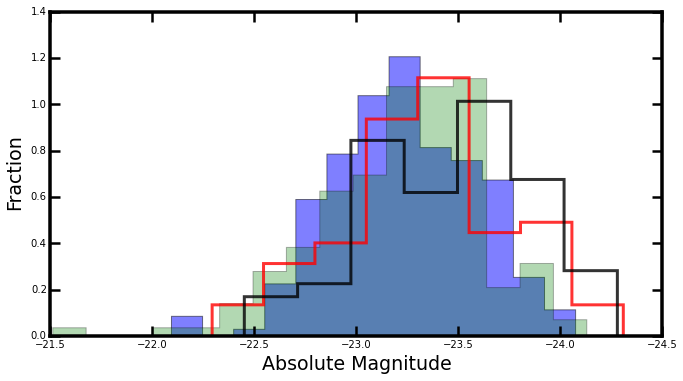

In [43]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

hist(mag_sbp_z4, bins='knuth', histtype='stepfilled', alpha=0.5, 
     normed=True, color='b')
hist(mag_sbp_z3, bins='knuth', histtype='stepfilled', alpha=0.3, 
     normed=True, color='g')
hist(mag_sbp_z2, bins='knuth', histtype='step', alpha=0.8, 
     normed=True, color='r', linewidth=3.0)
hist(mag_sbp_z1, bins='knuth', histtype='step', alpha=0.8, 
     normed=True, color='k', linewidth=3.0)

ax1.set_xlabel('Absolute Magnitude', size=19.0)
ax1.set_ylabel('Fraction', size=19.0)
ax1.set_xlim(-21.5, -24.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(19) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(19) 

### R1
### R2
### R3


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


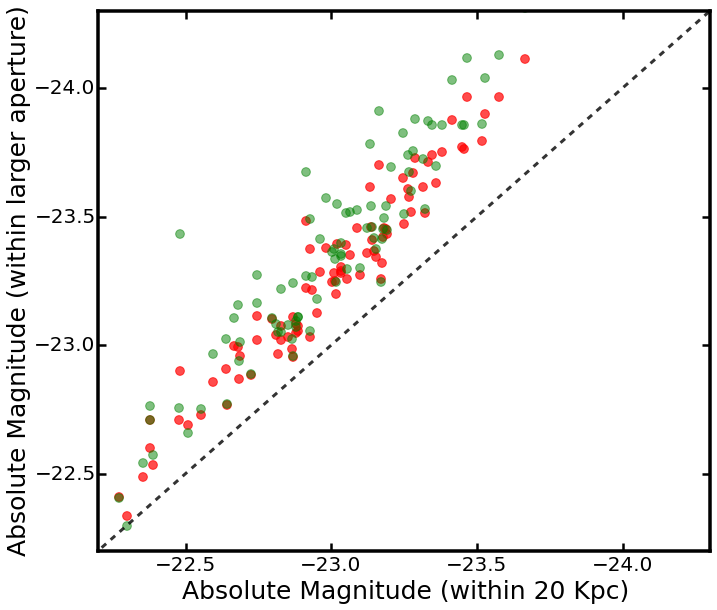

In [544]:
#def photoCompare(sample, zp=27.0, prefix='hsc_xmm_log11.6', amag_sun=amag_sun_i, 
#                 pix=0.168, absMag=True, aStr='extinction_i', verbose=False,
#                 magStr='cModelAbsMag_i', stage='3', plot=True, color='b', 
#                 radius=None, corCurve=False, idStr='objid_dr12', 
#                 massStr='logMass', zStr='z', extCorrect=True, ax=None, 
#                 marker='o'):


R1 = 20.0
R2 = 50.0 
R3 = 100.0
R4 = 120.0

sample = 'z2'

print "### R1"
mag_sbp_r1 = photoCompare(sample, radius=R1, plot=None)
print "### R2"
mag_sbp_r2 = photoCompare(sample, radius=R2, plot=None)
print "### R3"
mag_sbp_r3 = photoCompare(sample, radius=R3, plot=None)
#print "### R4"
#mag_sbp_r4 = photoCompare(sample, radius=R4, plot=None)

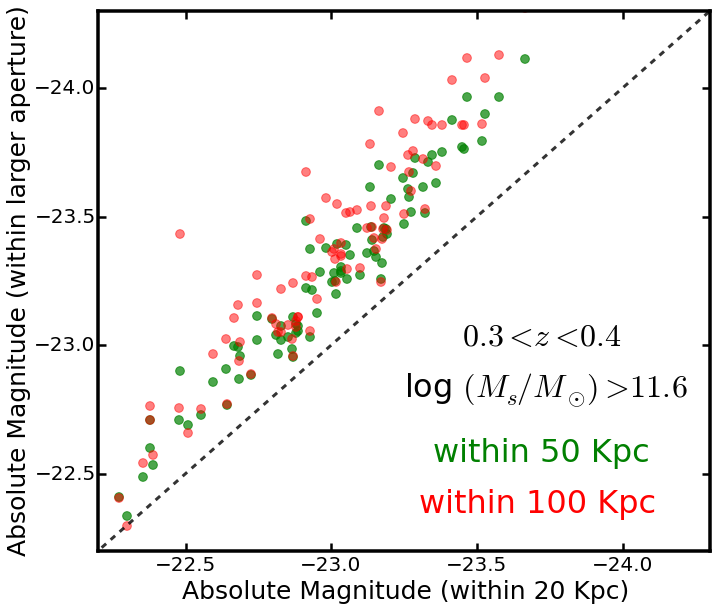

In [555]:

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

magRange = np.arange(-25.0, -20.0, 0.2)
ax1.plot(magRange, magRange, 'k', linestyle='--', linewidth=3.0, alpha=0.8)

ax1.scatter(mag_sbp_r1, mag_sbp_r2, marker='o', color='g', s=75, 
           alpha=0.7)
ax1.scatter(mag_sbp_r1, mag_sbp_r3, marker='o', color='r', s=75,
           alpha=0.5)
#ax1.scatter(mag_sbp_r1, mag_sbp_r4, marker='o', color='b')

ax1.set_xlim(-22.2, -24.3)
ax1.set_ylim(-22.2, -24.3)

ax1.set_xlabel('Absolute Magnitude (within 20 Kpc)',  size=25.0)
ax1.set_ylabel('Absolute Magnitude (within larger aperture)', size=25.0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(-23.45, -23.0, '$0.3<z<0.4$', size=32.0)
ax1.text(-23.25, -22.8, 'log $(M_{s}/M_{\odot})>11.6$', size=32.0)

ax1.text(-23.35, -22.55, 'within 50 Kpc', color='g', size=32.0)
ax1.text(-23.30, -22.35, 'within 100 Kpc', color='r', size=32.0)

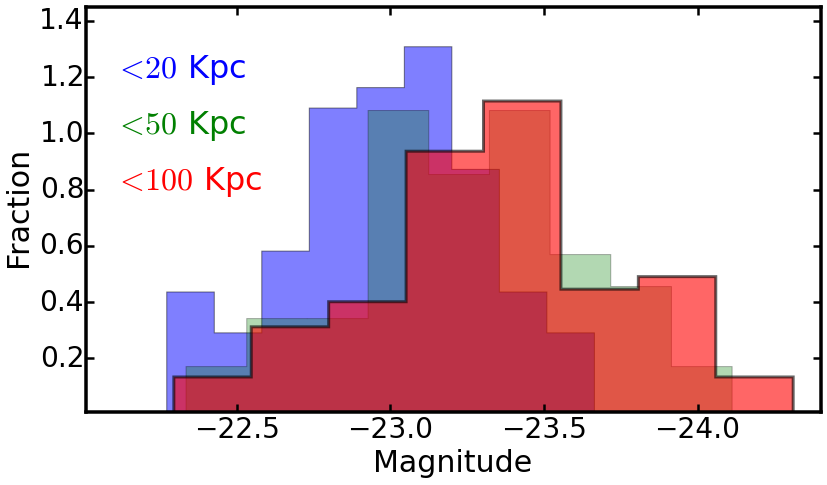

In [559]:
fig = plt.figure(figsize=(12, 7.5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

hist(mag_sbp_r1, bins='knuth', histtype='stepfilled', alpha=0.5, 
     normed=True, color='b')
hist(mag_sbp_r2, bins='knuth', histtype='stepfilled', alpha=0.3, 
     normed=True, color='g')
hist(mag_sbp_r3, bins='knuth', histtype='stepfilled', alpha=0.6, 
     normed=True, color='r', linewidth=3.0)
#hist(mag_sbp_r4, bins='knuth', histtype='step', alpha=0.8, 
#     normed=True, color='k', linewidth=3.0)

ax1.set_xlabel('Magnitude', size=30.0)
ax1.set_ylabel('Fraction', size=30.0)
ax1.set_xlim(-22.01, -24.4)
ax1.set_ylim(0.01, 1.45)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(-22.1, 1.2, '$<20$ Kpc', size=32, color='b')
ax1.text(-22.1, 1.0, '$<50$ Kpc', size=32, color='g')
ax1.text(-22.1, 0.8, '$<100$ Kpc', size=32, color='r')

## Average Profile

### Median Redshift : 0.283
 ## Median Magnitude : -22.30
 ## Median Log Stellar Mass : 11.71
37
37
### Median Redshift : 0.290
 ## Median Magnitude : -22.62
 ## Median Log Stellar Mass : 11.75
### Median Redshift : 0.281
 ## Median Magnitude : -22.85
 ## Median Log Stellar Mass : 11.81
(68, 37)


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


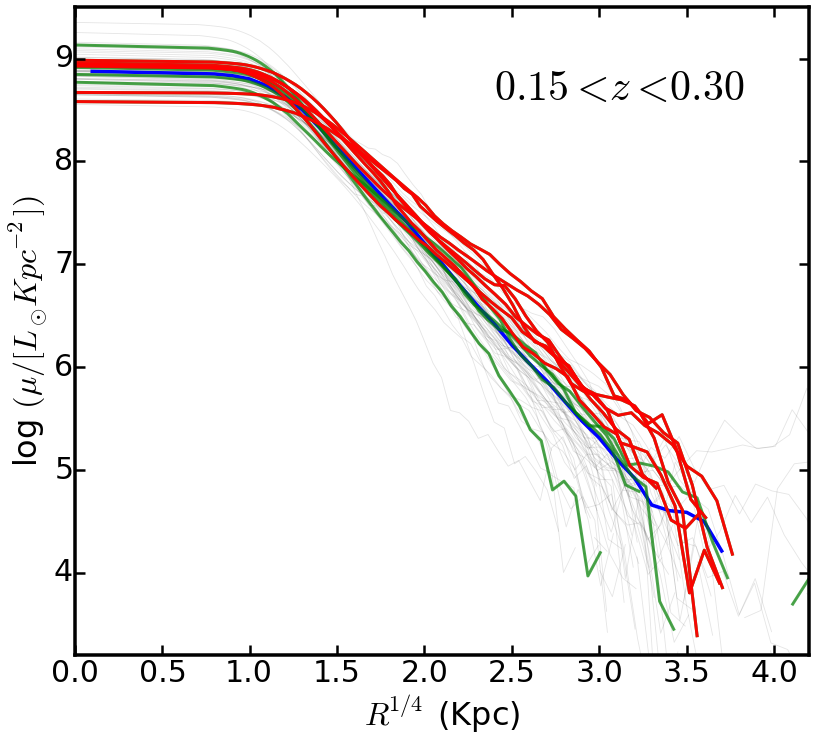

In [36]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_z1, asbp_avg_z1, asbp_stack_z1 = getStackProfile('z1', minRsma=0.1, maxRsma=3.8,
                                                             ax=ax1, alpha=0.1)

rsma_common_z1m, asbp_avg_z1m, asbp_stack_z1m = getStackProfile('z1', prefix='hsc_xmm_mem', minRsma=0.1, 
                                                                maxRsma=3.8, ax=ax1, alpha=0.7, plotAvg=False,
                                                                width=3.0, singleColor='g')
rsma_common_z1b, asbp_avg_z1b, asbp_stack_z1b = getStackProfile('z1', prefix='hsc_xmm_bcg', minRsma=0.1, 
                                                                maxRsma=3.8, ax=ax1, alpha=0.95, plotAvg=False, 
                                                                width=3.0, singleColor='r')

print asbp_stack_z1.shape

std_stack_z1 = np.nanstd(asbp_stack_z1, axis=0)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

### Median Redshift : 0.334
 ## Median Magnitude : -22.37
 ## Median Log Stellar Mass : 11.73
37
37
### Median Redshift : 0.333
 ## Median Magnitude : -22.35
 ## Median Log Stellar Mass : 11.72
### Median Redshift : 0.382
 ## Median Magnitude : -22.49
 ## Median Log Stellar Mass : 11.74
(89, 37)


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


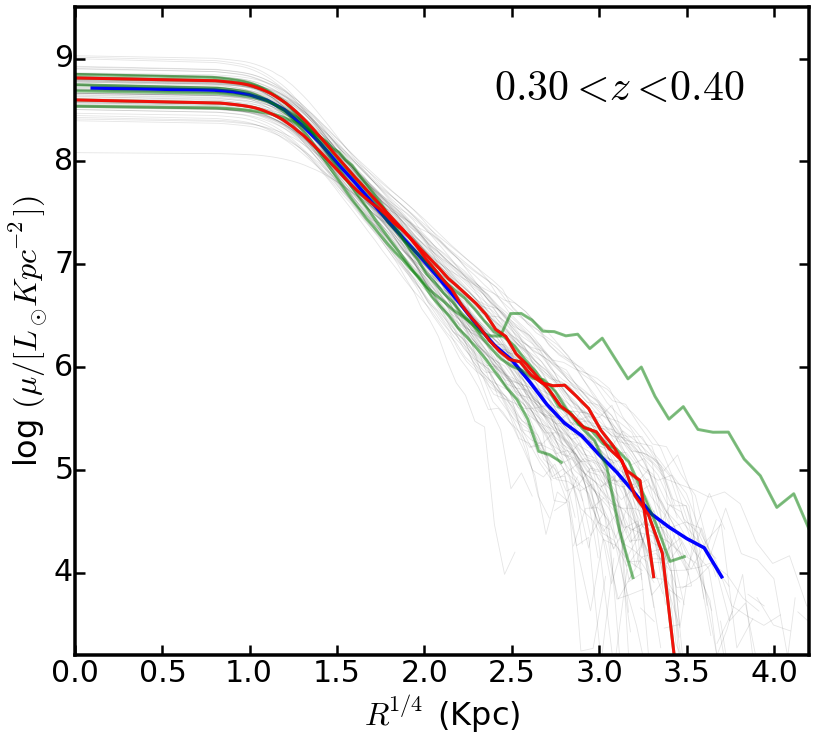

In [30]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_z2, asbp_avg_z2, asbp_stack_z2 = getStackProfile('z2', minRsma=0.1, maxRsma=3.8,
                                                             ax=ax1, alpha=0.1)
rsma_common_z2m, asbp_avg_z2m, asbp_stack_z2m = getStackProfile('z2', prefix='hsc_xmm_mem', minRsma=0.1, 
                                                                maxRsma=3.8, ax=ax1, alpha=0.5, plotAvg=False,
                                                                width=3.0, singleColor='g')
rsma_common_z2b, asbp_avg_z2b, asbp_stack_z2b = getStackProfile('z2', prefix='hsc_xmm_bcg', minRsma=0.1, 
                                                                maxRsma=3.8, ax=ax1, alpha=0.9, plotAvg=False,
                                                                width=3.0, singleColor='r')

print asbp_stack_z2.shape

std_stack_z2 = np.nanstd(asbp_stack_z2, axis=0)
#ax1.fill_between(rsma_common_z2, asbp_avg_z2+std_stack_z2, asbp_avg_z2-std_stack_z2,
#                 facecolor='b', alpha=0.2)

ax1.text(2.4, 8.6, '$0.30<z<0.40$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 

ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in log10


### Median Redshift : 0.458
 ## Median Magnitude : -22.50
 ## Median Log Stellar Mass : 11.76
37
37
### Median Redshift : 0.447
 ## Median Magnitude : -23.01
 ## Median Log Stellar Mass : 11.93
### Median Redshift : 0.446
 ## Median Magnitude : -23.09
 ## Median Log Stellar Mass : 11.97
(176, 37)


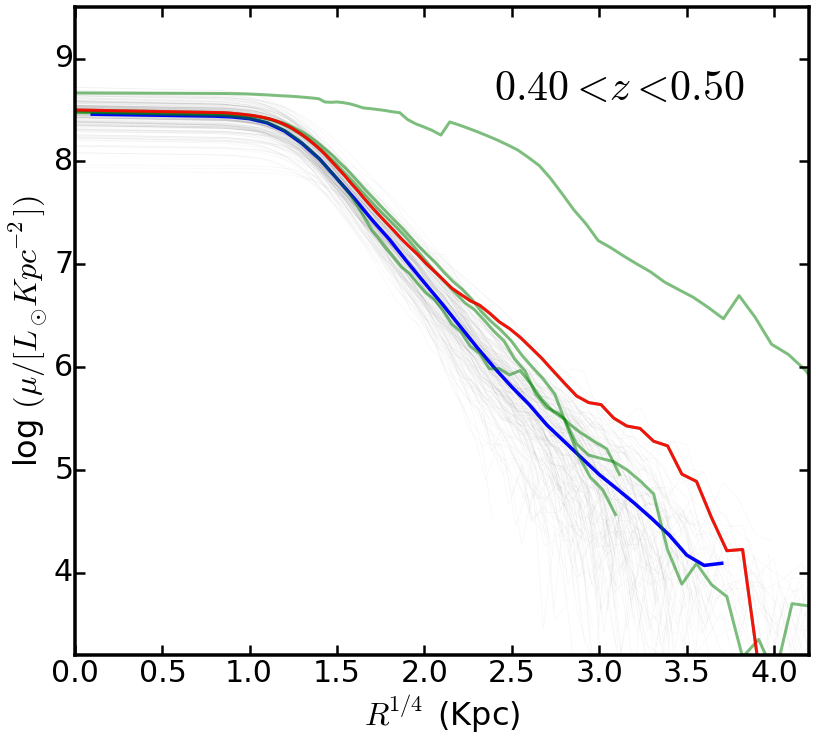

In [34]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_z3, asbp_avg_z3, asbp_stack_z3 = getStackProfile('z3', minRsma=0.1, maxRsma=3.8,
                                                             ax=ax1, alpha=0.03)
rsma_common_z3m, asbp_avg_z3m, asbp_stack_z3m = getStackProfile('z3', prefix='hsc_xmm_mem', minRsma=0.1, 
                                                                maxRsma=3.6, ax=ax1, alpha=0.5, plotAvg=False,
                                                                width=3.0, singleColor='g')
rsma_common_z3b, asbp_avg_z3b, asbp_stack_z3b = getStackProfile('z3', prefix='hsc_xmm_bcg', minRsma=0.1, 
                                                                maxRsma=3.6, ax=ax1, alpha=0.9, plotAvg=False,
                                                                width=3.0, singleColor='r')

print asbp_stack_z3.shape

std_stack_z3 = np.nanstd(asbp_stack_z3, axis=0)
#ax1.fill_between(rsma_common_z3, asbp_avg_z3+std_stack_z3, asbp_avg_z3-std_stack_z3,
#                 facecolor='b', alpha=0.2)

ax1.text(2.4, 8.6, '$0.40<z<0.50$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in log10


### Median Redshift : 0.555
 ## Median Magnitude : -22.66
 ## Median Log Stellar Mass : 11.75
(234, 37)


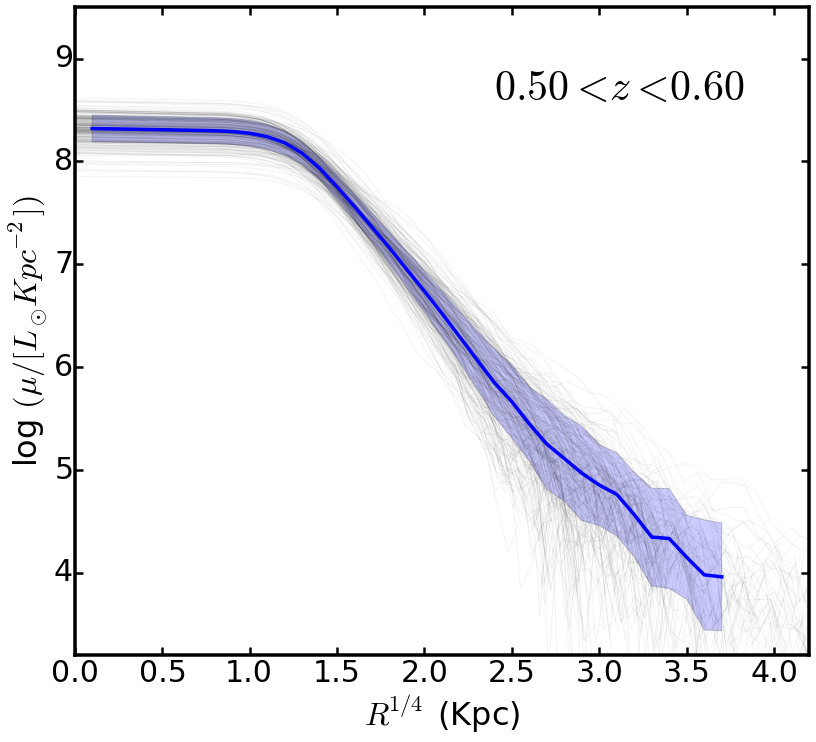

In [528]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_z4, asbp_avg_z4, asbp_stack_z4 = getStackProfile('z4', minRsma=0.1, maxRsma=3.8,
                                                             ax=ax1, alpha=0.05)

print asbp_stack_z4.shape

std_stack_z4 = np.nanstd(asbp_stack_z4, axis=0)
ax1.fill_between(rsma_common_z4, asbp_avg_z4+std_stack_z4, asbp_avg_z4-std_stack_z4,
                 facecolor='b', alpha=0.2)

ax1.text(2.4, 8.6, '$0.50<z<0.60$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

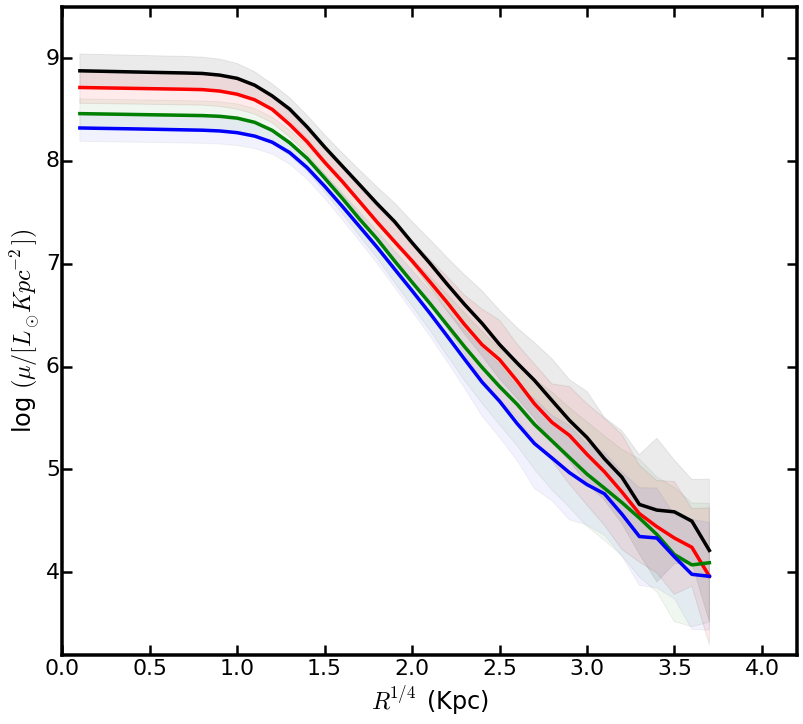

In [193]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot(rsma_common_z1, asbp_avg_z1, 'k', linewidth=3.5)
ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
                 facecolor='k', alpha=0.08)

ax1.plot(rsma_common_z2, asbp_avg_z2, 'r', linewidth=3.5)
ax1.fill_between(rsma_common_z2, asbp_avg_z2+std_stack_z2, asbp_avg_z2-std_stack_z2,
                 facecolor='r', alpha=0.08)

ax1.plot(rsma_common_z3, asbp_avg_z3, 'g', linewidth=3.5)
ax1.fill_between(rsma_common_z3, asbp_avg_z3+std_stack_z3, asbp_avg_z3-std_stack_z3,
                 facecolor='g', alpha=0.06)

ax1.plot(rsma_common_z4, asbp_avg_z4, 'b', linewidth=3.5)
ax1.fill_between(rsma_common_z4, asbp_avg_z4+std_stack_z4, asbp_avg_z4-std_stack_z4,
                 facecolor='b', alpha=0.05)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=24)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=24)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 

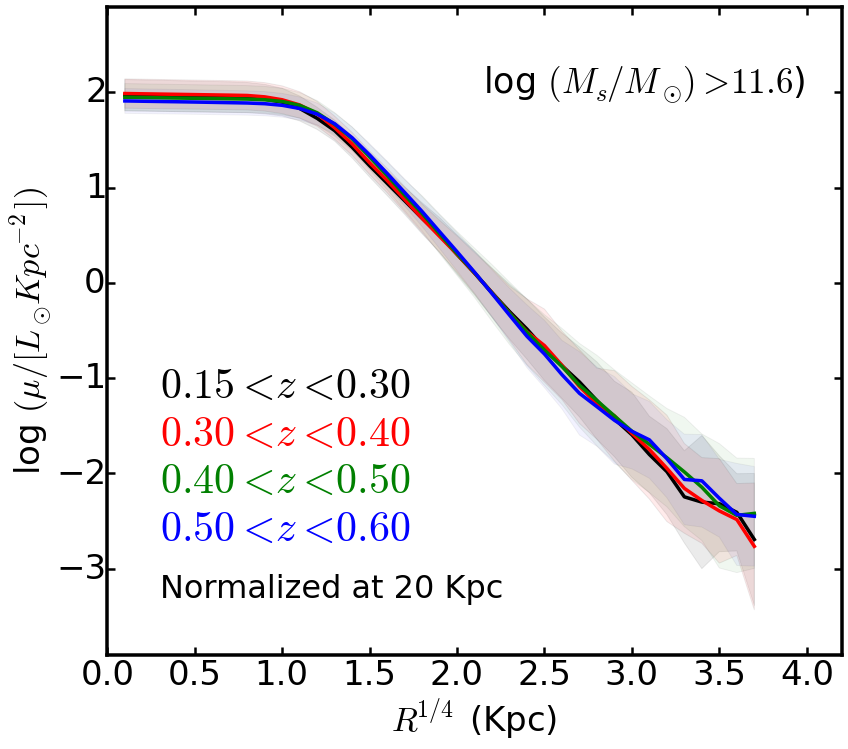

In [537]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

asbp_avg_z1norm = normProfile(rsma_common_z1, asbp_avg_z1, 2.1, 2.2)
asbp_avg_z2norm = normProfile(rsma_common_z2, asbp_avg_z2, 2.1, 2.2) 
asbp_avg_z3norm = normProfile(rsma_common_z3, asbp_avg_z3, 2.1, 2.2) 
asbp_avg_z4norm = normProfile(rsma_common_z4, asbp_avg_z4, 2.1, 2.2) 

ax1.plot(rsma_common_z1, asbp_avg_z1norm, 'k', linewidth=3.5)
ax1.fill_between(rsma_common_z1, asbp_avg_z1norm+std_stack_z1, asbp_avg_z1norm-std_stack_z1,
                 facecolor='k', alpha=0.08)

ax1.plot(rsma_common_z2, asbp_avg_z2norm, 'r', linewidth=3.5)
ax1.fill_between(rsma_common_z2, asbp_avg_z2norm+std_stack_z2, asbp_avg_z2norm-std_stack_z2,
                 facecolor='r', alpha=0.08)

ax1.plot(rsma_common_z3, asbp_avg_z3norm, 'g', linewidth=3.5)
ax1.fill_between(rsma_common_z3, asbp_avg_z3norm+std_stack_z3, asbp_avg_z3norm-std_stack_z3,
                 facecolor='g', alpha=0.06)

ax1.plot(rsma_common_z4, asbp_avg_z4norm, 'b', linewidth=3.5)
ax1.fill_between(rsma_common_z4, asbp_avg_z4norm+std_stack_z4, asbp_avg_z4norm-std_stack_z4,
                 facecolor='b', alpha=0.05)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=34)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=34)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(-3.9, 2.9)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(34) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(34) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(0.3, -1.2, '$0.15<z<0.30$', size=42, color='k')
ax1.text(0.3, -1.7, '$0.30<z<0.40$', size=42, color='r')
ax1.text(0.3, -2.2, '$0.40<z<0.50$', size=42, color='g')
ax1.text(0.3, -2.7, '$0.50<z<0.60$', size=42, color='b')

ax1.text(0.3, -3.3, 'Normalized at 20 Kpc', size=32, color='k')

ax1.text(2.15, 2.0, 'log $(M_{s}/M_{\odot}) > 11.6$)', size=35, color='k')

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


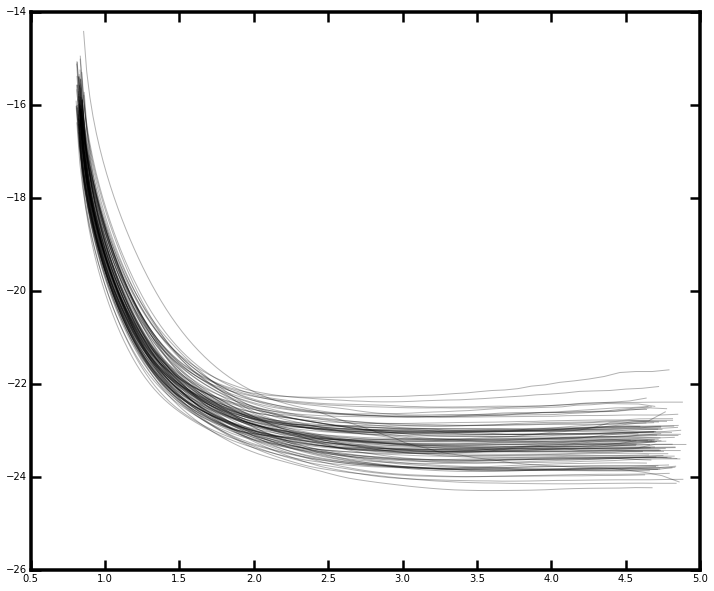

In [65]:
for ii in range(len(catData)): 
    
    ellProf = getEllipProfile(gal_id[ii], loc, stage='3')
    
    if ellProf is not None:
        sma_kpc, asbp_i, amag_i = correctProf(ellProf, gal_z[ii], extinction=gal_ai[ii], zp=27.0, 
                                              verbose=False, amag_sun=amag_sun_i)
    
        plot(sma_kpc**0.25, amag_i, color='k', alpha=0.3)

## XMM Good BCGs 

### Median Redshift : 0.335
### Can not find the column : extinction_i
 ## Median Magnitude : 17.56
### Can not find the column : logMass
(40, 39)


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


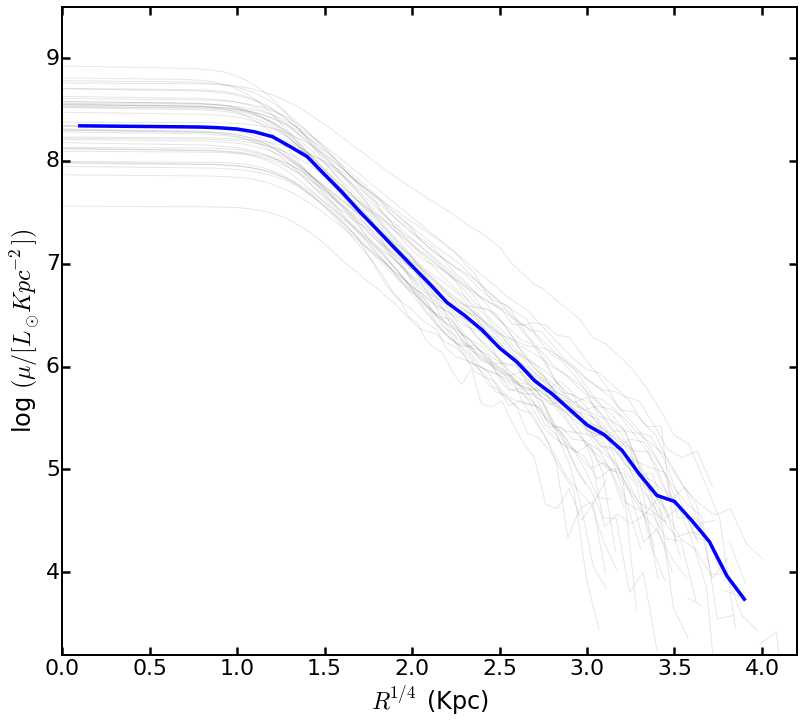

In [561]:
#def getStackProfile(sample, zp=27.0, prefix='hsc_xmm_log11.6', amag_sun=amag_sun_i, 
#                    pix=0.168, absMag=True, aStr='extinction_i', verbose=False,
#                    magStr='cModelAbsMag_i', stage='3', plot=True, color='b', 
#                    radius=None, corCurve=False, useMedian=True, 
#                    minRsma=0.3, maxRsma=3.5, extCorrect=True, idStr='objid_dr12', 
#                    zStr='z', massStr='logMass', rsmaStep=0.1, ax=None, root=None, 
#                    idSuffix=None, dirSuffix=None, catFile=None)

clusterRoot = '/Users/songhuang/Downloads/hsc_cutout/xmm_cluster'
clusterCat = 'xmm_cluster_good.fits'
bandUse = 'r'

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_bcg_r, asbp_avg_bcg_r, asbp_stack_bcg_r = getStackProfile('good', root=clusterRoot, catFile=clusterCat,
                                                                      dirSuffix=bandUse, minRsma=0.1, maxRsma=4.0,
                                                                      ax=ax1, idStr='ID', zStr='Z_LAMBDA', 
                                                                      magStr='IMAG')

print asbp_stack_bcg_r.shape

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=24)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=24)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 

### Median Redshift : 0.335
### Can not find the column : extinction_i
 ## Median Magnitude : 17.56
### Can not find the column : logMass


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


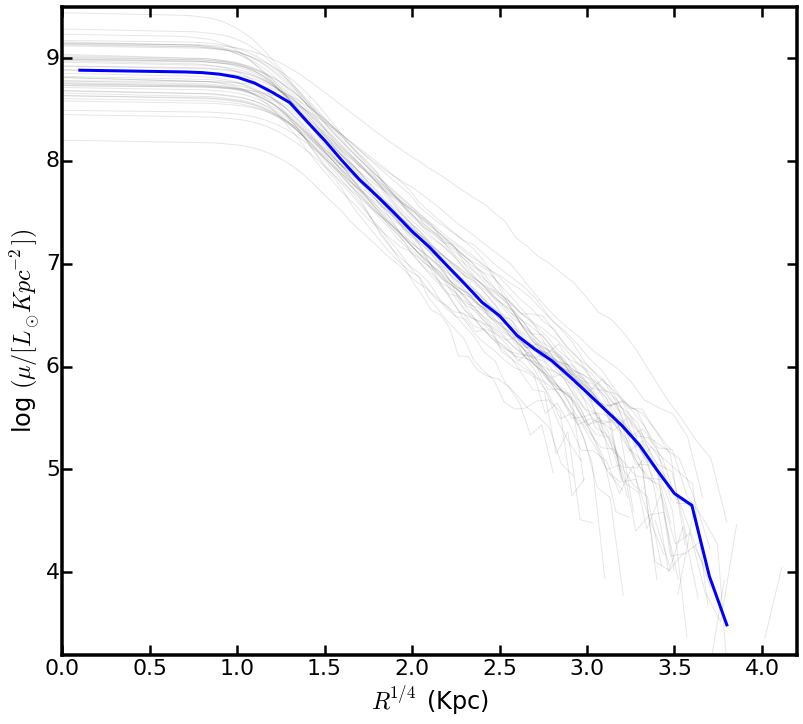

In [196]:
#def getStackProfile(sample, zp=27.0, prefix='hsc_xmm_log11.6', amag_sun=amag_sun_i, 
#                    pix=0.168, absMag=True, aStr='extinction_i', verbose=False,
#                    magStr='cModelAbsMag_i', stage='3', plot=True, color='b', 
#                    radius=None, corCurve=False, useMedian=True, 
#                    minRsma=0.3, maxRsma=3.5, extCorrect=True, idStr='objid_dr12', 
#                    zStr='z', massStr='logMass', rsmaStep=0.1, ax=None, root=None, 
#                    idSuffix=None, dirSuffix=None, catFile=None)

clusterRoot = '/Users/songhuang/Downloads/hsc_cutout/xmm_cluster'
clusterCat = 'xmm_cluster_good.fits'
bandUse = 'z'


fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_bcg_z, asbp_avg_bcg_z, asbp_stack_bcg_z = getStackProfile('good', root=clusterRoot, catFile=clusterCat,
                                                                      dirSuffix=bandUse, minRsma=0.1, maxRsma=4.0,
                                                                      ax=ax1, idStr='ID', zStr='Z_LAMBDA', 
                                                                      magStr='IMAG')

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=24)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=24)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 

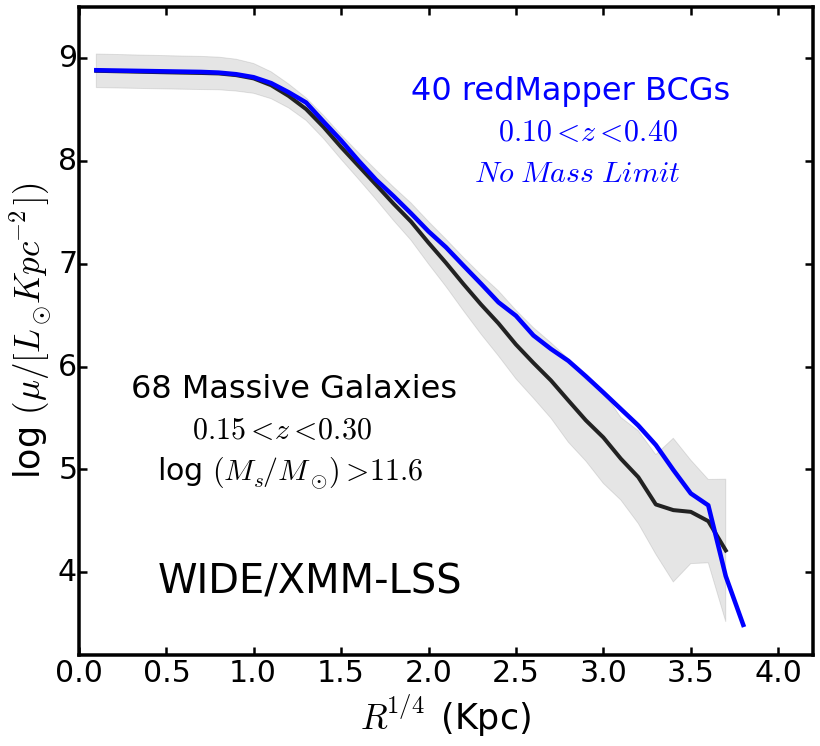

In [590]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot(rsma_common_z1, asbp_avg_z1, 'k', linewidth=4.0, alpha=0.85)
ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
                 facecolor='k', alpha=0.1)

ax1.plot(rsma_common_bcg_z, asbp_avg_bcg_z, color='b', linewidth=4.5)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=35)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=35)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(1.90, 8.6, '40 redMapper BCGs', size=32, color='b')
ax1.text(2.40, 8.2, '$0.10<z<0.40$', size=30, color='b')
ax1.text(2.26, 7.8, '${\t{No\ Mass\ Limit}}$', size=30, color='b')

ax1.text(0.30, 5.7, '68 Massive Galaxies', size=32, color='k')
ax1.text(0.65, 5.3, '$0.15<z<0.30$', size=30, color='k')
ax1.text(0.45, 4.9, 'log $(M_{s}/M_{\odot})>11.6$', size=30, color='k')

ax1.text(0.46, 3.8, 'WIDE/XMM-LSS', size=40, color='k')

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

asbp_avg_z1norm = normProfile(rsma_common_z1, asbp_avg_z1, 2.2, 2.3)
asbp_avg_z2norm = normProfile(rsma_common_z2, asbp_avg_z2, 2.2, 2.3) 
asbp_avg_z3norm = normProfile(rsma_common_z3, asbp_avg_z3, 2.2, 2.3) 
asbp_avg_z4norm = normProfile(rsma_common_z4, asbp_avg_z4, 2.2, 2.3) 
asbp_avg_bcgNorm_z = normProfile(rsma_common_bcg_z, asbp_avg_bcg_z, 2.2, 2.3)


ax1.plot(rsma_common_z1, asbp_avg_z1norm, 'k', linewidth=3.5)
ax1.fill_between(rsma_common_z1, asbp_avg_z1norm+std_stack_z1, asbp_avg_z1norm-std_stack_z1,
                 facecolor='k', alpha=0.05)

ax1.plot(rsma_common_z2, asbp_avg_z2norm, 'r', linewidth=3.5)
ax1.fill_between(rsma_common_z2, asbp_avg_z2norm+std_stack_z2, asbp_avg_z2norm-std_stack_z2,
                 facecolor='r', alpha=0.05)

ax1.plot(rsma_common_bcg_z, asbp_avg_bcgNorm_z, color='b', linewidth=4.0)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=24)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=24)

ax1.set_xlim(0.0, 4.2)
#ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 

## COSMOS Massive 

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in log10


### Median Redshift : 0.529
### Can not find the column : extinction_i
 ## Median Magnitude : 20.98
 ## Median Log Stellar Mass : 10.70


/usr/local/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:469: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


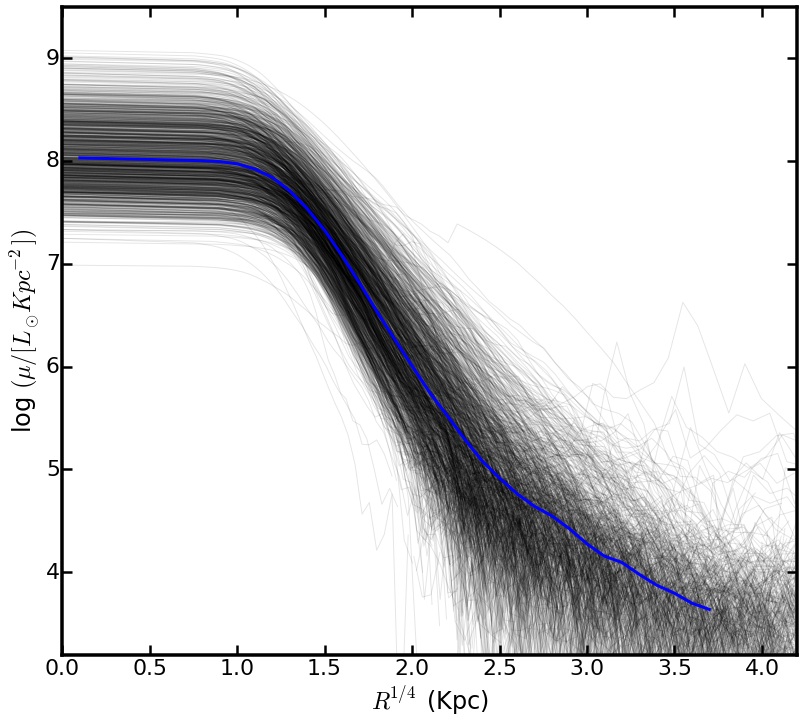

In [175]:
cosmosRoot = '/Users/songhuang/Downloads/hsc_cutout/cos_massive'
cosmosCat = 'cos_massive_sample.fits'

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_cos, asbp_avg_cos, asbp_stack_cos = getStackProfile('prof', root=cosmosRoot, catFile=cosmosCat,
                                                                 minRsma=0.1, maxRsma=3.8, ax=ax1, 
                                                                 idStr='CATAID', zStr='z', 
                                                                 magStr='F814W_08', massStr='logm')

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=24)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=24)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 

### Median Redshift : 0.701
### Can not find the column : extinction_i
 ## Median Magnitude : 20.85
 ## Median Log Stellar Mass : 11.50


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


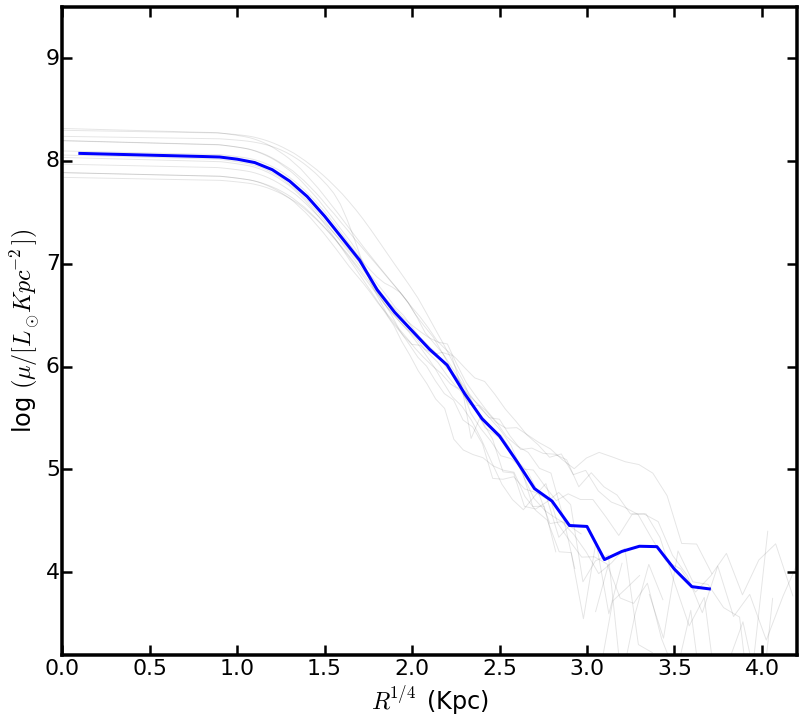

In [180]:
cosmosRoot = '/Users/songhuang/Downloads/hsc_cutout/cos_massive'
cosmosCat = 'cos_massive_csample1.fits'

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

rsma_common_compact, asbp_avg_compact, asbp_stack_cospact = getStackProfile('prof', root=cosmosRoot, catFile=cosmosCat,
                                                                 minRsma=0.1, maxRsma=3.8, ax=ax1, 
                                                                 idStr='CATAID', zStr='z', 
                                                                 magStr='F814W_08', massStr='logm')

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=24)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=24)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 

### Median Redshift : 0.692
### Can not find the column : extinction_i
 ## Median Magnitude : 20.78
 ## Median Log Stellar Mass : 11.36
### Median Redshift : 0.701
### Can not find the column : extinction_i
 ## Median Magnitude : 20.85
 ## Median Log Stellar Mass : 11.50


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


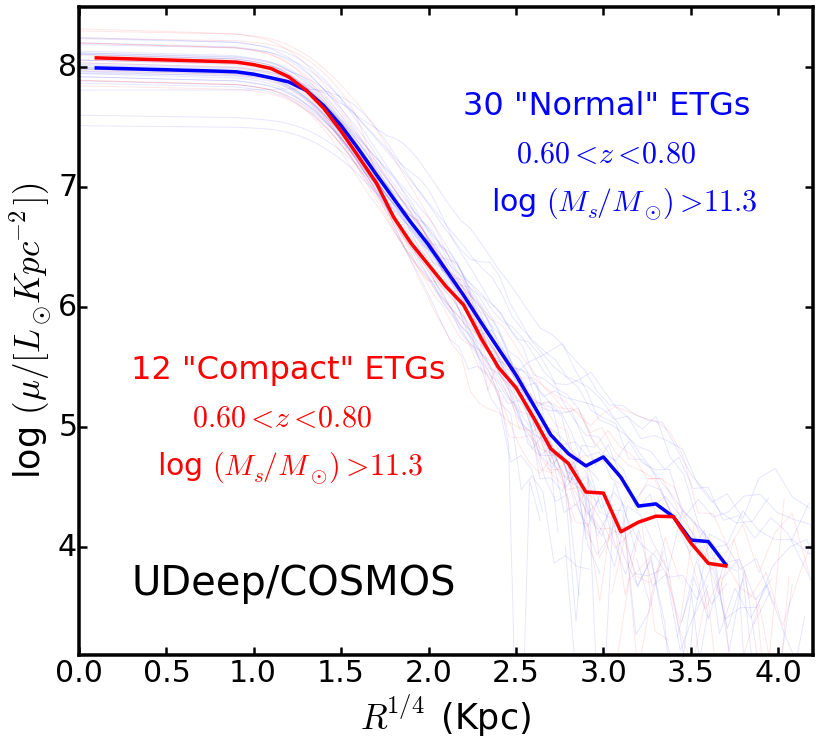

In [591]:

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

cosmosRoot = '/Users/songhuang/Downloads/hsc_cutout/cos_massive'
cosmosCat = 'cos_massive_sample3.fits'

rsma_common_cos1, asbp_avg_cos1, asbp_stack_cos1 = getStackProfile('prof', root=cosmosRoot, catFile=cosmosCat,
                                                                 minRsma=0.1, maxRsma=3.8, ax=ax1, 
                                                                 idStr='CATAID', zStr='z', singleColor='b',
                                                                 magStr='F814W_08', massStr='logm')

cosmosCat = 'cos_massive_csample1.fits'

rsma_common_compact, asbp_avg_compact, asbp_stack_cospact = getStackProfile('prof', root=cosmosRoot, catFile=cosmosCat,
                                                                 minRsma=0.1, maxRsma=3.8, ax=ax1, color='r',
                                                                 idStr='CATAID', zStr='z', singleColor='r',
                                                                 magStr='F814W_08', massStr='logm')

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=35)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=35)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(3.1, 8.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.text(2.20, 7.6, '30 "Normal" ETGs', size=32, color='b')
ax1.text(2.50, 7.2, '$0.60<z<0.80$', size=30, color='b')
ax1.text(2.36, 6.8, 'log $(M_{s}/M_{\odot})>11.3$', size=30, color='b')

ax1.text(0.30, 5.4, '12 "Compact" ETGs', size=32, color='r')
ax1.text(0.65, 5.0, '$0.60<z<0.80$', size=30, color='r')
ax1.text(0.45, 4.6, 'log $(M_{s}/M_{\odot})>11.3$', size=30, color='r')

ax1.text(0.32, 3.6, 'UDeep/COSMOS', size=40, color='k')


#ax1.plot(rsma_common_compact, asbp_avg_compact, color='r', linewidth=3.5)

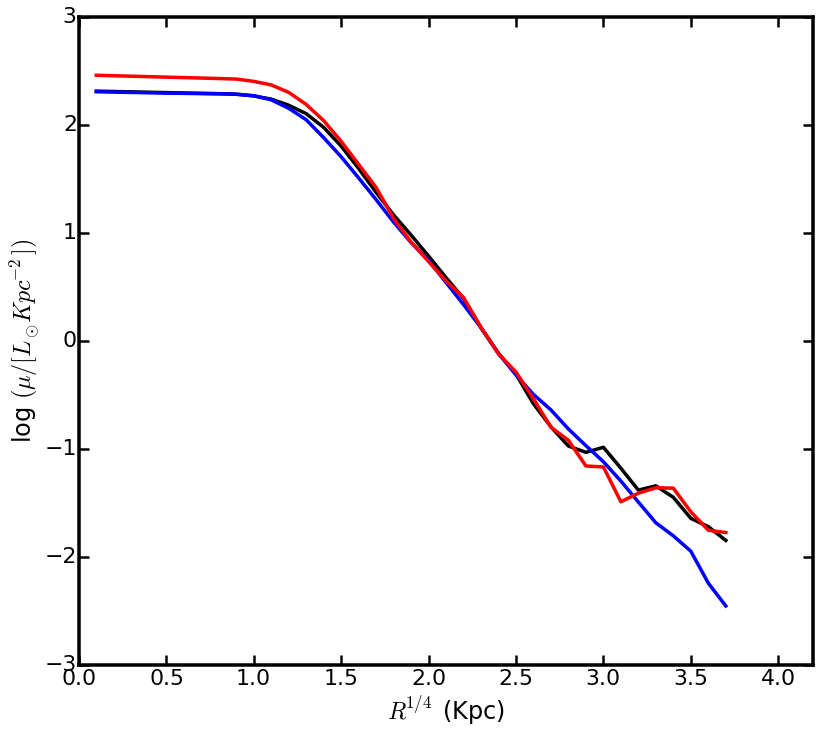

In [184]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

asbp_avg_cos_norm_1 = normProfile(rsma_common_cos1, asbp_avg_cos1, 2.3, 2.5)
asbp_avg_cos_norm_2 = normProfile(rsma_common_cos2, asbp_avg_cos2, 2.3, 2.5) 
asbp_avg_cos_norm_c = normProfile(rsma_common_compact, asbp_avg_compact, 2.3, 2.5) 

ax1.plot(rsma_common_cos1, asbp_avg_cos_norm_1, 'k', linewidth=3.5)

ax1.plot(rsma_common_cos2, asbp_avg_cos_norm_2, 'b', linewidth=3.5)

ax1.plot(rsma_common_compact, asbp_avg_cos_norm_c, 'r', linewidth=3.5)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=24)
ax1.set_ylabel('log $(\mu/[L_{\odot} Kpc^{-2}])$', size=24)

ax1.set_xlim(0.0, 4.2)
#ax1.set_ylim(3.2, 9.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 

# Test of .pkl file 

In [208]:
loc = '/Users/songhuang/Downloads/hsc_cutout/cos_massive/galfit'
pklFile = 'cosmos_6006354_HSC-I_full_1ser.pkl'

obj1Ser = loadGalfitOutput(os.path.join(loc, pklFile))

In [211]:
print obj1Ser.reduced_chisq

1.048929


In [212]:
obj1Ser.component_1.re * obj1Ser.component_1.ar

1.7477975300000002

In [274]:
obj1Ser.component_1.n

6.9677

In [216]:
import coaddCutoutGalfitSimple as gSimple 

aic, bic, hq = gSimple.galfitAIC(obj1Ser)
print aic, bic, hq

132882.56314 132980.054414 132887.199341


In [228]:
cosmosDir = '/Users/songhuang/Downloads/hsc_cutout/cos_massive'
cosmosPklDir = os.path.join(cosmosDir, 'galfit')

cosmosCat = os.path.join(cosmosDir, 'cos_massive_sample.fits')

cosmosData = fits.open(cosmosCat)[1].data

In [301]:
pix = 0.168
chisqThr = 4.0

galZ   = []
galMs  = []
galRe  = []
galEll = []
galMag = []
galNs  = []
gal814 = []

galReHSC  = []
galEllHSC = []
galMagHSC = []
galNsHSC = []

chi1Ser = []
aic1Ser = []
bic1Ser = []

for galaxy in cosmosData: 
    
    galId = galaxy['CATAID']
    pattern1Ser = '*' + str(galId) + '*1ser.pkl'
    
    pklFound = findProfile(pattern1Ser, cosmosPklDir)
    
    if len(pklFound) == 1:
        
        pklFile = pklFound[0]
        obj1Ser = loadGalfitOutput(pklFile)
        
        nser = obj1Ser.component_1.n
        chisq = obj1Ser.reduced_chisq
        
        if (chisq <= chisqThr) and (nser < 8.0):
    
            scale = galaxy['scale']
            distmod = hUtil.cosmoDistMod(galaxy['z'])
            
            galZ.append(galaxy['z'])
            galMs.append(galaxy['logm'])
            galRe.append(galaxy['re'])
            galEll.append(galaxy['ell'])
            galMag.append(galaxy['Imag3'] - distmod)
            gal814.append(-2.5 * np.log10(galaxy['FLUX_GIM2D']) + 27.0 - distmod)
            galNs.append(galaxy['SERSIC_N_GIM2D'])
        
            aic, bic, hq = gSimple.galfitAIC(obj1Ser)
        
            chi1Ser.append(chisq)
            aic1Ser.append(aic)
            bic1Ser.append(bic)
        
            galReHSC.append(obj1Ser.component_1.re * 0.168 * scale)
            galEllHSC.append(1.0 - obj1Ser.component_1.ar)
            galMagHSC.append(obj1Ser.component_1.mag - 0.03 - distmod)
            galNsHSC.append(obj1Ser.component_1.n)

            
print "### Number of models : %d" % len(galRe)
        
galZ   = np.asarray(galZ)
galMs  = np.asarray(galMs)
galRe  = np.asarray(galRe)
galEll = np.asarray(galEll)

galReHSC  = np.asarray(galReHSC)
galEllHSC = np.asarray(galEllHSC)
galNsHSC = np.asarray(galNsHSC)

chi1Ser = np.asarray(chi1Ser)
aic1Ser = np.asarray(aic1Ser)
bic1Ser = np.asarray(bic1Ser)

### Number of models : 1030


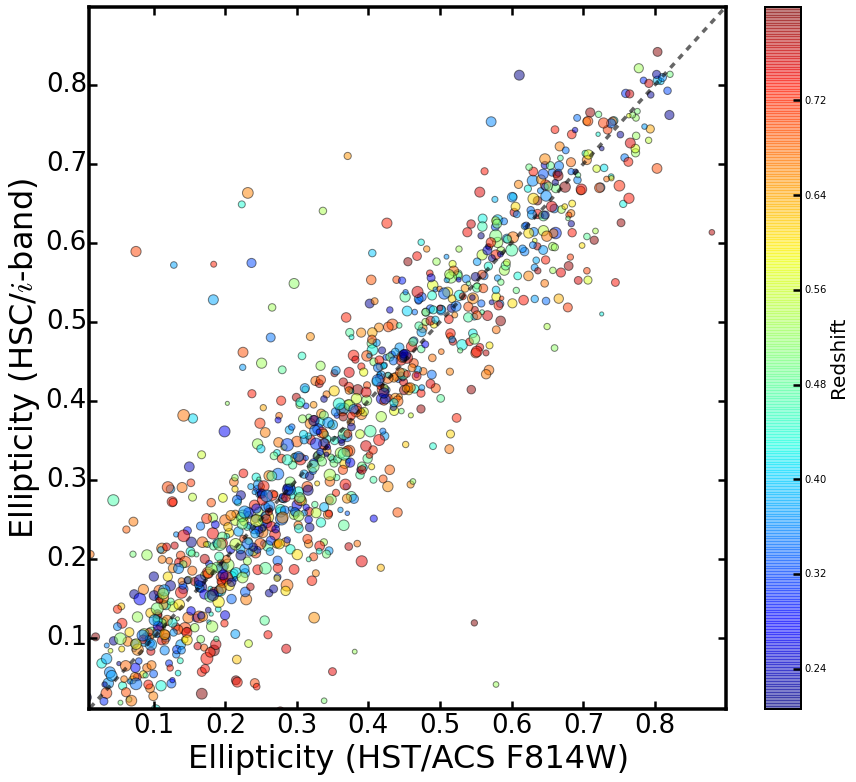

In [594]:
fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot([0.0,0.5,1.1], [0.0,0.5,1.1], 'k--', alpha=0.6,
        linewidth=3.5)

sca = ax1.scatter(galEll, galEllHSC, alpha=0.5, c=galZ, s=(galMs-9.8)*80.0)

ax1.set_xlabel('Ellipticity (HST/ACS F814W)', size=32)
ax1.set_ylabel('Ellipticity (HSC/$i$-band)', size=32)

ax1.set_xlim(0.01, 0.899)
ax1.set_ylim(0.01, 0.899)

cbar = fig.colorbar(sca)
cbar.set_label('Redshift', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

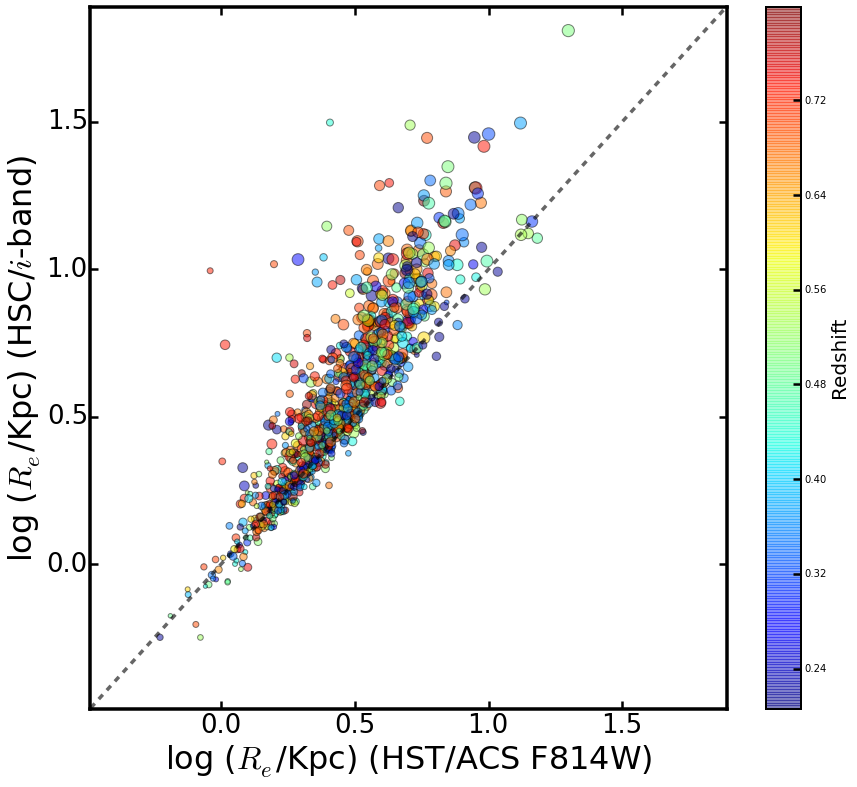

In [597]:
fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot([-3.0,105.1], [-3.0, 105.1], 'k--', alpha=0.6, linewidth=3.5)

sca = ax1.scatter(np.log10(galRe), np.log10(galReHSC), alpha=0.5, 
                  c=galZ, s=(galMs-9.8)*80.0)

ax1.set_xlabel('log ($R_e$/Kpc) (HST/ACS F814W)', size=32)
ax1.set_ylabel('log ($R_e$/Kpc) (HSC/$i$-band)', size=32)

ax1.set_xlim(-0.49, 1.89)
ax1.set_ylim(-0.49, 1.89)

cbar = fig.colorbar(sca)
cbar.set_label('Redshift', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

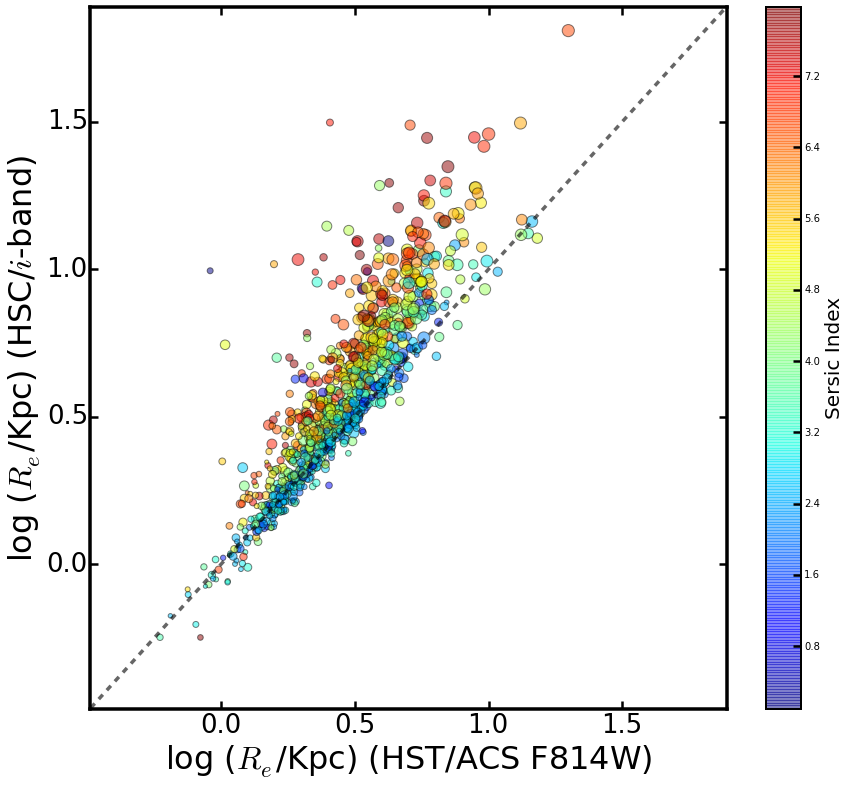

In [596]:
fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot([-3.0,105.1], [-3.0, 105.1], 'k--', alpha=0.6, linewidth=3.5)

sca = ax1.scatter(np.log10(galRe), np.log10(galReHSC), alpha=0.5, 
                  c=galNsHSC, s=(galMs-9.8)*80.0)

ax1.set_xlabel('log ($R_e$/Kpc) (HST/ACS F814W)', size=32)
ax1.set_ylabel('log ($R_e$/Kpc) (HSC/$i$-band)', size=32)

ax1.set_xlim(-0.49, 1.89)
ax1.set_ylim(-0.49, 1.89)

cbar = fig.colorbar(sca)
cbar.set_label('Sersic Index', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

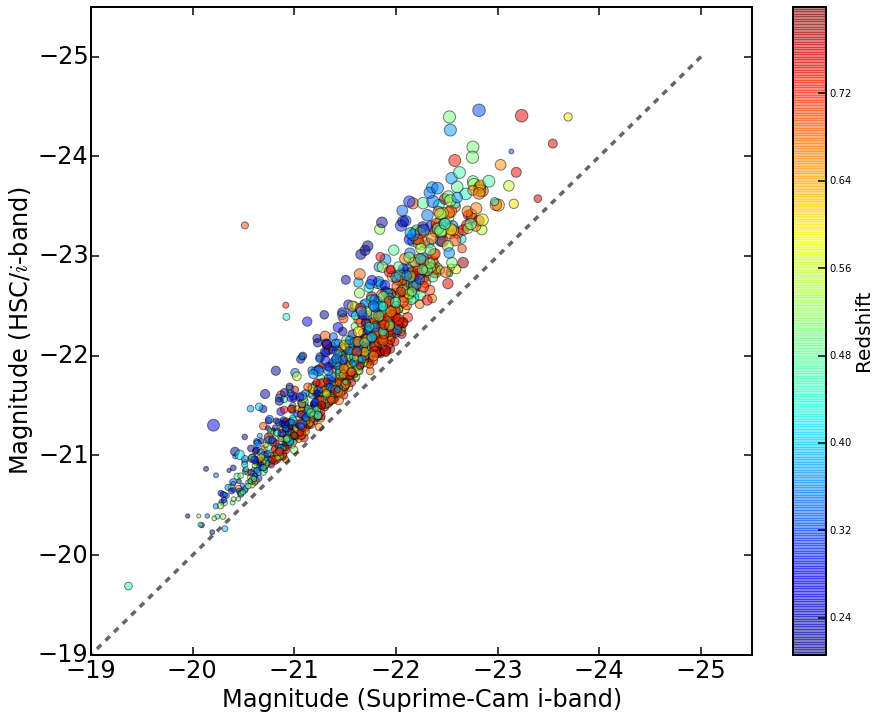

In [302]:
fig = plt.figure(figsize=(13.5, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot([-25.0,-10.1], [-25.0, -10.1], 'k--', alpha=0.6, 
         linewidth=3.5)

sca = ax1.scatter(galMag, galMagHSC, c=galZ, alpha=0.5, 
                  s=(galMs-9.8)*80.0)

ax1.set_xlabel('Magnitude (Suprime-Cam i-band)', size=24)
ax1.set_ylabel('Magnitude (HSC/$i$-band)', size=24)

ax1.set_xlim(-19.0, -25.5)
ax1.set_ylim(-19.0, -25.5)

cbar = fig.colorbar(sca)
cbar.set_label('Redshift', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 

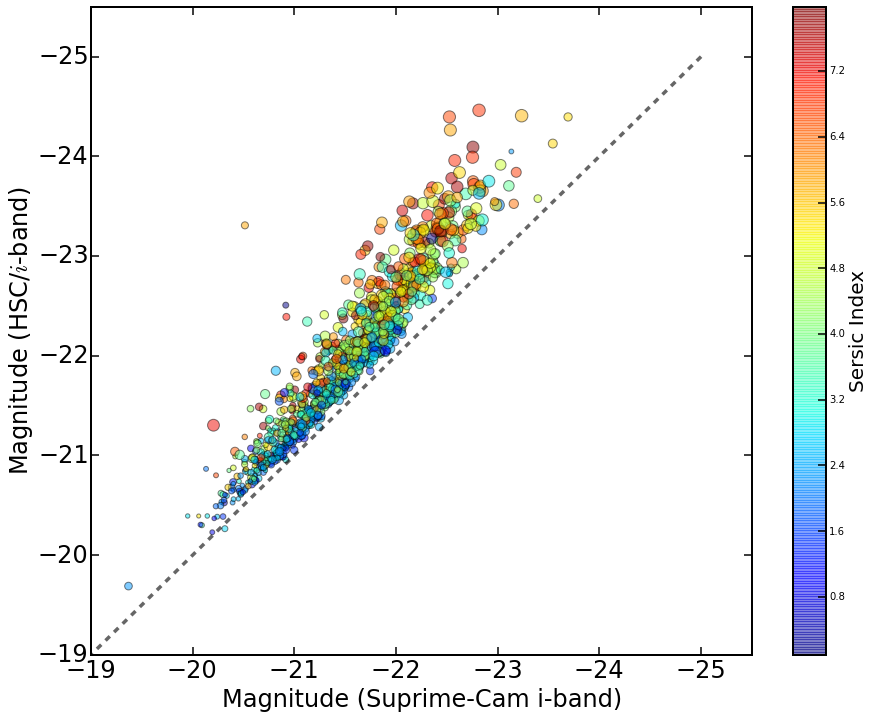

In [303]:
fig = plt.figure(figsize=(13.5, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot([-25.0,-10.1], [-25.0, -10.1], 'k--', alpha=0.6, 
         linewidth=3.5)

sca = ax1.scatter(galMag, galMagHSC, c=galNsHSC, alpha=0.5, 
                  s=(galMs-9.8)*80.0)

ax1.set_xlabel('Magnitude (Suprime-Cam i-band)', size=24)
ax1.set_ylabel('Magnitude (HSC/$i$-band)', size=24)

ax1.set_xlim(-19.0, -25.5)
ax1.set_ylim(-19.0, -25.5)

cbar = fig.colorbar(sca)
cbar.set_label('Sersic Index', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 

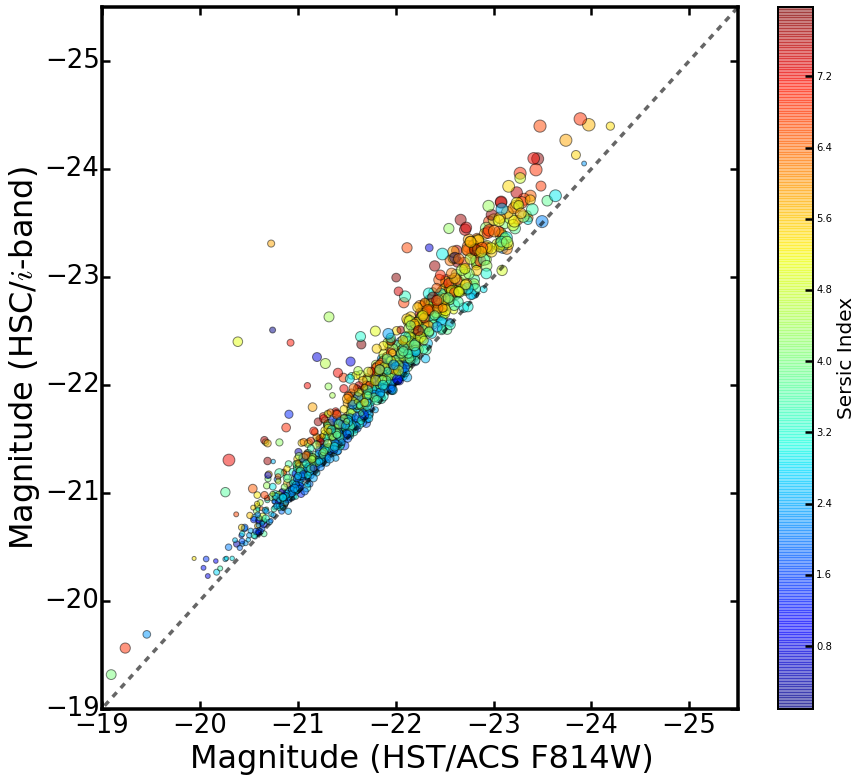

In [595]:
fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot([-25.9,-10.1], [-25.9, -10.1], 'k--', alpha=0.6, 
         linewidth=3.5)

sca = ax1.scatter(np.asarray(gal814)+7.2, galMagHSC, c=galNsHSC, alpha=0.5, 
                  s=(galMs-9.8)*80.0)

ax1.set_xlabel('Magnitude (HST/ACS F814W)', size=32)
ax1.set_ylabel('Magnitude (HSC/$i$-band)', size=32)

ax1.set_xlim(-19.0, -25.5)
ax1.set_ylim(-19.0, -25.5)

cbar = fig.colorbar(sca)
cbar.set_label('Sersic Index', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

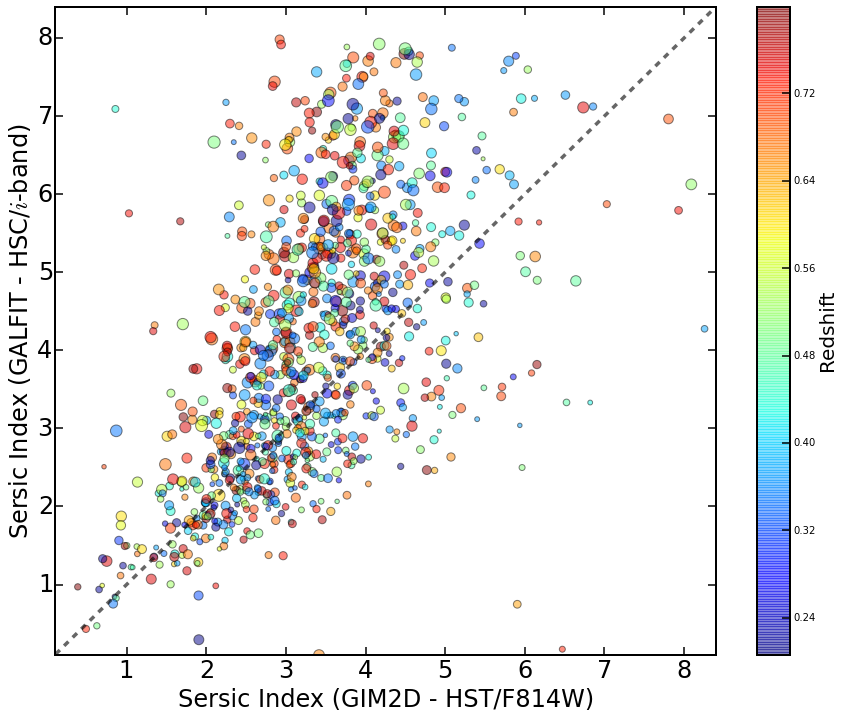

In [322]:
fig = plt.figure(figsize=(13.5, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.plot([0.0, 8.5], [0.0, 8.5], 'k--', alpha=0.6, 
         linewidth=3.5)

sca = ax1.scatter(galNs, galNsHSC, c=galZ, alpha=0.5, 
                  s=(galMs-9.8)*80.0)

ax1.set_xlabel('Sersic Index (GIM2D - HST/F814W)', size=24)
ax1.set_ylabel('Sersic Index (GALFIT - HSC/$i$-band)', size=24)

ax1.set_xlim(0.1, 8.4)
ax1.set_ylim(0.1, 8.4)

cbar = fig.colorbar(sca)
cbar.set_label('Redshift', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 

# XMM_ETG & XMM_Massive

In [412]:
xmmEtgDir = '/Users/songhuang/Downloads/hsc_cutout/xmm_etg/'

xmmEtg2PklDir = os.path.join(xmmEtgDir, 'xmm_ell_2_galfit')
xmmEtg3PklDir = os.path.join(xmmEtgDir, 'xmm_ell_3_galfit')

xmmEtg2Cat = os.path.join(xmmEtgDir, 'hsc_sdss_xmm_nearby_ell_z0.05_0.13.fits')
xmmEtg3Cat = os.path.join(xmmEtgDir, 'hsc_sdss_xmm_nearby_ell_z0.16_0.24.fits')

xmmEtg2Data = fits.open(xmmEtg2Cat)[1].data
xmmEtg3Data = fits.open(xmmEtg3Cat)[1].data

In [413]:
xmassDir = '/Users/songhuang/Downloads/hsc_cutout/xmm_massive/'

xmassZ1PklDir = os.path.join(xmassDir, 'galfit/z1_i')
xmassZ2PklDir = os.path.join(xmassDir, 'galfit/z2_i')
xmassZ3PklDir = os.path.join(xmassDir, 'galfit/z3_i')
xmassZ4PklDir = os.path.join(xmassDir, 'galfit/z4_i')

xmassZ1Cat = os.path.join(xmassDir, 'hsc_xmm_log11.6_z1.fits')
xmassZ2Cat = os.path.join(xmassDir, 'hsc_xmm_log11.6_z2.fits')
xmassZ3Cat = os.path.join(xmassDir, 'hsc_xmm_log11.6_z3.fits')
xmassZ4Cat = os.path.join(xmassDir, 'hsc_xmm_log11.6_z4.fits')

xmassZ1Data = fits.open(xmassZ1Cat)[1].data
xmassZ2Data = fits.open(xmassZ2Cat)[1].data
xmassZ3Data = fits.open(xmassZ3Cat)[1].data
xmassZ4Data = fits.open(xmassZ4Cat)[1].data

In [414]:
def get1SerSize(cat, pklDir, zStr='z', idStr='objid_dr12', pix=0.168, 
                chisqThr=4.0, nSerThr=8.0, extinctionStr='extinction_i'):
    
    galUse = np.empty(len(cat), dtype=bool)
    galUse[:] = False
    
    galRe1Ser = []
    galAr1Ser = []
    galMag1Ser = []
    galNs1Ser = []

    chi1Ser = []
    aic1Ser = []
    bic1Ser = []

    for ii, galaxy in enumerate(cat): 
                
        galId = galaxy[idStr]
        pattern1Ser = '*' + str(galId) + '*1ser.pkl'
        pattern2Ser = '*' + str(galId) + '*2ser.pkl'
        
        pkl1SerFound = findProfile(pattern1Ser, pklDir)
        pkl1SerFound = findProfile(pattern1Ser, pklDir)

        if len(pkl1SerFound) == 1:
            
            pkl1SerFile = pkl1SerFound[0]
            obj1Ser = loadGalfitOutput(pkl1SerFile)
            
            if type(obj1Ser) is not numpy.core.records.recarray:
            
                nser1Ser  = obj1Ser.component_1.n
                chisq1Ser = obj1Ser.reduced_chisq
            
                try: 
                    ai = galaxy[extinctionStr]
                except Exception:
                    ai = 0.05
            
                if (chisq1Ser <= chisqThr) and (nser1Ser < nSerThr):
                
                    scale = pixKpc(galaxy[zStr], show=False)
                    distmod = hUtil.cosmoDistMod(galaxy[zStr])
                
                    aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
                
                    chi1Ser.append(chisq1Ser)
                    aic1Ser.append(aic1)
                    bic1Ser.append(bic1)
        
                    galRe1Ser.append(obj1Ser.component_1.re * scale)
                    galAr1Ser.append(obj1Ser.component_1.ar)
                    galMag1Ser.append(obj1Ser.component_1.mag - ai - distmod)
                    galNs1Ser.append(obj1Ser.component_1.n)
                    
                    galUse[ii] = True
                    
    print "### Number of models : %d" % len(galRe1Ser)
    
    return galUse, galRe1Ser, galAr1Ser, galMag1Ser, galNs1Ser, chi1Ser, bic1Ser

In [415]:
xEtg2Use, xEtg2Re, xEtg2Ar, xEtg2Mag, xEtg2Ns, xEtg2Chi, xEtg2Bic = get1SerSize(xmmEtg2Data, xmmEtg2PklDir, 
                                                                                zStr='z', idStr='id', pix=0.168, 
                                                                                chisqThr=10.0, nSerThr=8.0, 
                                                                                extinctionStr='extinction_i')
xEtg3Use, xEtg3Re, xEtg3Ar, xEtg3Mag, xEtg3Ns, xEtg3Chi, xEtg3Bic = get1SerSize(xmmEtg3Data, xmmEtg3PklDir, 
                                                                                zStr='z', idStr='id', pix=0.168, 
                                                                                chisqThr=10.0, nSerThr=8.0, 
                                                                                extinctionStr='extinction_i')

### Number of models : 19
### Number of models : 156


In [418]:
xMass1Use, xMass1Re, xMass1Ar, xMass1Mag, xMass1Ns, xMass1Chi, xMass1Bic = get1SerSize(xmassZ1Data, xmassZ1PklDir, 
                                                                                       zStr='z', idStr='objid_dr12', 
                                                                                       pix=0.168, chisqThr=10.0, 
                                                                                       nSerThr=8.0, 
                                                                                       extinctionStr='extinction_i')
xMass2Use, xMass2Re, xMass2Ar, xMass2Mag, xMass2Ns, xMass2Chi, xMass2Bic = get1SerSize(xmassZ2Data, xmassZ2PklDir, 
                                                                                       zStr='z', idStr='objid_dr12', 
                                                                                       pix=0.168, chisqThr=10.0, 
                                                                                       nSerThr=8.0, 
                                                                                       extinctionStr='extinction_i')
xMass3Use, xMass3Re, xMass3Ar, xMass3Mag, xMass3Ns, xMass3Chi, xMass3Bic = get1SerSize(xmassZ3Data, xmassZ3PklDir, 
                                                                                       zStr='z', idStr='objid_dr12', 
                                                                                       pix=0.168, chisqThr=10.0, 
                                                                                       nSerThr=8.0, 
                                                                                       extinctionStr='extinction_i')
xMass4Use, xMass4Re, xMass4Ar, xMass4Mag, xMass4Ns, xMass4Chi, xMass4Bic = get1SerSize(xmassZ4Data, xmassZ4PklDir, 
                                                                                       zStr='z', idStr='objid_dr12', 
                                                                                       pix=0.168, chisqThr=10.0, 
                                                                                       nSerThr=8.0, 
                                                                                       extinctionStr='extinction_i')

### Number of models : 32
### Number of models : 72
### Number of models : 144
### Number of models : 189


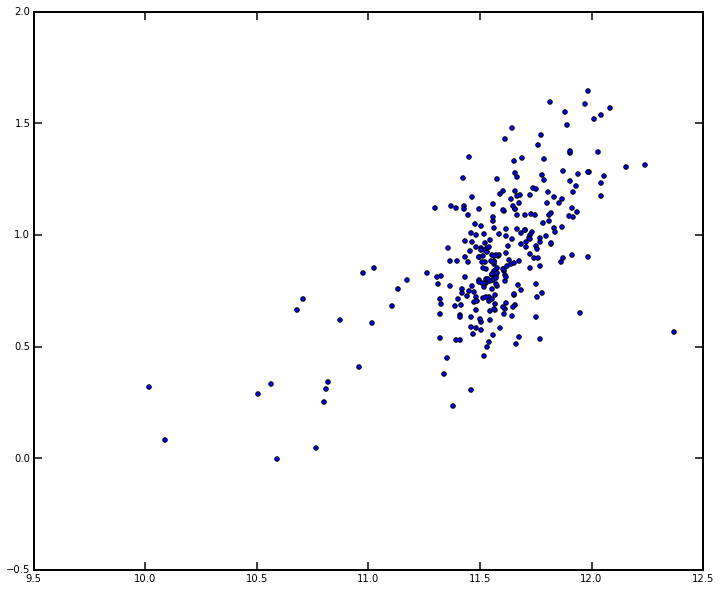

In [467]:
xEtg2logm = xmmEtg2Data[xEtg2Use]['logms_pca']
xEtg3logm = xmmEtg3Data[xEtg3Use]['logms_pca']
scatter(xEtg2logm, np.log10(np.asarray(xEtg2Re)*np.asarray(xEtg2Ar)))
scatter(xEtg3logm, np.log10(np.asarray(xEtg3Re)*np.asarray(xEtg3Ar)))

xMass1logm = xmassZ1Data[xMass1Use]['logms_pca_bc03']
xMass2logm = xmassZ2Data[xMass2Use]['logms_pca_bc03']
xMass3logm = xmassZ3Data[xMass3Use]['logms_pca_bc03']
xMass4logm = xmassZ4Data[xMass4Use]['logms_pca_bc03']

scatter(xMass1logm, np.log10(np.asarray(xMass1Re)*np.asarray(xMass1Ar)))
scatter(xMass2logm, np.log10(np.asarray(xMass2Re)*np.asarray(xMass2Ar)))
#scatter(xMass3logm, np.log10(np.asarray(xMass3Re)*np.asarray(xMass3Ar)))
#scatter(xMass4logm, np.log10(np.asarray(xMass4Re)*np.asarray(xMass4Ar)))

In [508]:
def get2SerSize(cat, pklDir, zStr='z', idStr='objid_dr12', pix=0.168, 
                chisqThr=4.0, nSerThr=8.0, extinctionStr='extinction_i', 
                factor=0.95, massStr='logms_pca'):
    
    galUse = np.empty(len(cat), dtype=bool)
    galUse[:] = False
    
    galRe1Ser = []
    galAr1Ser = []
    galMag1Ser = []
    galNs1Ser = []

    chi1Ser = []
    aic1Ser = []
    bic1Ser = []
    
    galRe2SerI = []
    galAr2SerI = []
    galMag2SerI = []
    galNs2SerI = []
    
    galRe2SerO = []
    galAr2SerO = []
    galMag2SerO = []
    galNs2SerO = []
    
    innerFrac = []
    
    chi2Ser = []
    aic2Ser = []
    bic2Ser = []
    
    logmI = []
    logmO = []
    
    for ii, galaxy in enumerate(cat): 
                
        galId = galaxy[idStr]
        pattern1Ser = '*' + str(galId) + '*1ser.pkl'
        pattern2Ser = '*' + str(galId) + '*2ser.pkl'
        
        pkl1SerFound = findProfile(pattern1Ser, pklDir)
        pkl2SerFound = findProfile(pattern2Ser, pklDir)

        if (len(pkl1SerFound) == 1) and (len(pkl2SerFound) == 1):
            
            pkl1SerFile = pkl1SerFound[0]
            obj1Ser = loadGalfitOutput(pkl1SerFile)
            
            pkl2SerFile = pkl2SerFound[0]
            obj2Ser = loadGalfitOutput(pkl2SerFile)
            
            if (type(obj1Ser) is not numpy.core.records.recarray) and (
                type(obj2Ser) is not numpy.core.records.recarray):
            
                nser2A = obj1Ser.component_1.n
                nser2B = obj2Ser.component_2.n
                
                chisq1 = obj1Ser.reduced_chisq
                aic1, bic1, hq1 = gSimple.galfitAIC(obj1Ser)
                
                chisq2 = obj1Ser.reduced_chisq
                aic2, bic2, hq2 = gSimple.galfitAIC(obj2Ser)
            
                try: 
                    ai = galaxy[extinctionStr]
                except Exception:
                    ai = 0.05
            
                logmT = galaxy[massStr]

                if (logmT >= 11.2) and (bic2 < bic1) and (aic2 < aic1) and (
                    nser2A <= nSerThr) and (nser2B <= nSerThr):
                
                    scale = pixKpc(galaxy[zStr], show=False)
                    distmod = hUtil.cosmoDistMod(galaxy[zStr])
                
                    chi1Ser.append(chisq1)
                    aic1Ser.append(aic1)
                    bic1Ser.append(bic1)
        
                    galRe1Ser.append(obj1Ser.component_1.re * np.sqrt(obj1Ser.component_1.ar) * scale)
                    galAr1Ser.append(obj1Ser.component_1.ar)
                    galMag1Ser.append(obj1Ser.component_1.mag - ai - distmod)
                    galNs1Ser.append(obj1Ser.component_1.n)
                    
                    """ 2 Sersic part """
                    chi2Ser.append(chisq2)
                    aic2Ser.append(aic2)
                    bic2Ser.append(bic2)
                    
                    if (obj2Ser.component_1.re <= obj2Ser.component_2.re): 
                        compInner = obj2Ser.component_1
                        compOuter = obj2Ser.component_2
                    else: 
                        compInner = obj2Ser.component_2 
                        compOuter = obj2Ser.component_1

                    galRe2SerI.append(compInner.re * scale * np.sqrt(compInner.ar))
                    galAr2SerI.append(compInner.ar)
                    galMag2SerI.append(compInner.mag)
                    galNs2SerI.append(compInner.n)

                    galRe2SerO.append(compOuter.re * scale * np.sqrt(compOuter.ar))
                    galAr2SerO.append(compOuter.ar)
                    galMag2SerO.append(compOuter.mag)
                    galNs2SerO.append(compOuter.n)  
                                        
                    fluxI = 10.0 ** ((27.0 - compInner.mag) / 2.5)
                    fluxO = 10.0 ** ((27.0 - compOuter.mag) / 2.5)
                    innerFrac.append(fluxI / (fluxI + fluxO))
                    
                    logmI.append(logmT + np.log10(fluxI / (fluxI + fluxO)))
                    logmO.append(logmT + np.log10(fluxO / (fluxI + fluxO)))

                    galUse[ii] = True
                    
    print "### Number of models : %d" % len(galRe1Ser)
    
    return galRe2SerI, galRe2SerO, logmI, logmO

In [509]:
xEtg3ReI, xEtg3ReO, xEtg3logmI, xEtg3logmO = get2SerSize(xmmEtg3Data, xmmEtg3PklDir, zStr='z', idStr='id', 
                                                         chisqThr=5.0, nSerThr=6.0, massStr='logms_pca')

xEtg2ReI, xEtg2ReO, xEtg2logmI, xEtg2logmO = get2SerSize(xmmEtg2Data, xmmEtg2PklDir, zStr='z', idStr='id', 
                                                         chisqThr=5.0, nSerThr=6.0, massStr='logms_pca')

### Number of models : 89
### Number of models : 6


In [510]:
xMass1ReI, xMass1ReO, xMass1logmI, xMass1logmO = get2SerSize(xmassZ1Data, xmassZ1PklDir, zStr='z', 
                                                             idStr='objid_dr12', chisqThr=5.0, nSerThr=6.0, 
                                                             massStr='logms_pca_bc03')
xMass2ReI, xMass2ReO, xMass2logmI, xMass2logmO = get2SerSize(xmassZ2Data, xmassZ2PklDir, zStr='z', 
                                                             idStr='objid_dr12', chisqThr=5.0, nSerThr=6.0, 
                                                             massStr='logms_pca_bc03')
xMass3ReI, xMass3ReO, xMass3logmI, xMass3logmO = get2SerSize(xmassZ3Data, xmassZ3PklDir, zStr='z', 
                                                             idStr='objid_dr12', chisqThr=5.0, nSerThr=6.0, 
                                                             massStr='logms_pca_bc03')
xMass4ReI, xMass4ReO, xMass4logmI, xMass4logmO = get2SerSize(xmassZ4Data, xmassZ4PklDir, zStr='z', 
                                                             idStr='objid_dr12', chisqThr=5.0, nSerThr=6.0, 
                                                             massStr='logms_pca_bc03')

### Number of models : 24
### Number of models : 47
### Number of models : 77
### Number of models : 91


In [505]:
cgsInner = fits.open('cgs_inner.fits')[1].data
cgsOuter = fits.open('cgs_outer.fits')[1].data
cgsMass = fits.open('cgs_massive.fits')[1].data

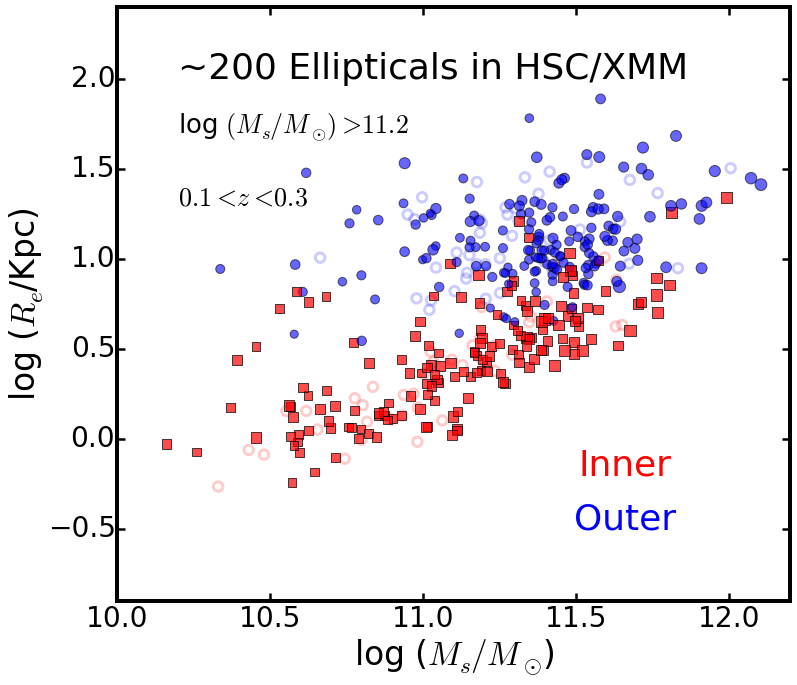

In [611]:
fig = plt.figure(figsize=(11.0, 11.0))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

#ax1.plot([-25.9,-10.1], [-25.9, -10.1], 'k--', alpha=0.6, 
#         linewidth=3.5)

""" CGS """

ax1.scatter(cgsMass['logm_inner']+0.15, np.log10(cgsMass['re_inner']),
            s=90, color='r', linewidth=3.0,
            facecolor='none', alpha=0.2)

ax1.scatter(cgsMass['logm_outer']+0.15, np.log10(cgsMass['re_outer']), 
            s=90, color='b', linewidth=3.0,
            facecolor='none', alpha=0.2)

""" 1 Sersic """
#xEtg2logm = xmmEtg2Data[xEtg2Use]['logms_pca']
#xEtg3logm = xmmEtg3Data[xEtg3Use]['logms_pca']

#ax1.scatter(xEtg2logm, np.log10(np.asarray(xEtg2Re)*np.asarray(xEtg2Ar)), 
#            color='k', alpha=0.6)
#ax1.scatter(xEtg3logm, np.log10(np.asarray(xEtg3Re)*np.asarray(xEtg3Ar)), 
#            color='k', alpha=0.6)

#xMass1logm = xmassZ1Data[xMass1Use]['logms_pca_bc03']
#xMass2logm = xmassZ2Data[xMass2Use]['logms_pca_bc03']
#xMass3logm = xmassZ3Data[xMass3Use]['logms_pca_bc03']
#xMass4logm = xmassZ4Data[xMass4Use]['logms_pca_bc03']

#ax1.scatter(xMass1logm, np.log10(np.asarray(xMass1Re)*np.asarray(xMass1Ar)), 
#            color='k', alpha=0.6)
#ax1.scatter(xMass2logm, np.log10(np.asarray(xMass2Re)*np.asarray(xMass2Ar)), 
#            color='k', alpha=0.6)
#ax1.scatter(xMass3logm, np.log10(np.asarray(xMass3Re)*np.asarray(xMass3Ar)), 
#            color='k', alpha=0.6)
#ax1.scatter(xMass4logm, np.log10(np.asarray(xMass4Re)*np.asarray(xMass4Ar)), 
#            color='k', alpha=0.6)

""" 2 Sersic """

xEtg3logmT = logAdd(xEtg3logmI, xEtg3logmO)
ax1.scatter(xEtg3logmI, np.log10(np.asarray(xEtg3ReI)), s=(xEtg3logmT-10.5)*80, 
            c='r', alpha=0.7, marker='s')
ax1.scatter(xEtg3logmO, np.log10(np.asarray(xEtg3ReO)), s=(xEtg3logmT-10.5)*80, 
            c='b', alpha=0.6)

xEtg2logmT = logAdd(xEtg2logmI, xEtg2logmO)
ax1.scatter(xEtg2logmI, np.log10(np.asarray(xEtg2ReI)), s=(xEtg2logmT-10.5)*80, 
            c='r', alpha=0.7, marker='s')
ax1.scatter(xEtg2logmO, np.log10(np.asarray(xEtg2ReO)), s=(xEtg2logmT-10.5)*80, 
            c='b', alpha=0.6)

xMass1logmT = logAdd(xMass1logmI, xMass1logmO)
ax1.scatter(xMass1logmI, np.log10(np.asarray(xMass1ReI)), s=(xMass1logmT-10.5)*80, 
            c='r', alpha=0.7, marker='s')
ax1.scatter(xMass1logmO, np.log10(np.asarray(xMass1ReO)), s=(xMass1logmT-10.5)*80, 
            c='b', alpha=0.6)

xMass2logmT = logAdd(xMass2logmI, xMass2logmO)
ax1.scatter(xMass2logmI, np.log10(np.asarray(xMass2ReI)), s=(xMass2logmT-10.5)*80, 
            c='r', alpha=0.7, marker='s')
ax1.scatter(xMass2logmO, np.log10(np.asarray(xMass2ReO)), s=(xMass2logmT-10.5)*80, 
            c='b', alpha=0.6)

xMass3logmT = logAdd(xMass3logmI, xMass3logmO)
#ax1.scatter(xMass3logmI, np.log10(np.asarray(xMass3ReI)), s=(xMass3logmT-10.5)*80, 
#            c='r', alpha=0.7, marker='s')
#ax1.scatter(xMass3logmO, np.log10(np.asarray(xMass3ReO)), s=(xMass3logmT-10.5)*80, 
#            c='b', alpha=0.6)

xMass4logmT = logAdd(xMass4logmI, xMass4logmO)
#ax1.scatter(xMass4logmI, np.log10(np.asarray(xMass4ReI)), s=(xMass4logmT-10.0)*80, 
#            c='r', alpha=0.9, marker='s')
#ax1.scatter(xMass4logmO, np.log10(np.asarray(xMass4ReO)), s=(xMass4logmT-10.0)*80, 
#            c='b', alpha=0.8)

ax1.set_xlabel('log ($M_{s}/M_{\odot}$)', size=33)
ax1.set_ylabel('log ($R_{e}$/Kpc)', size=33)

ax1.set_xlim(10.0, 12.2)
ax1.set_ylim(-0.9, 2.4)

#cbar = fig.colorbar(sca)
#cbar.set_label('Sersic Index', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)
    
ax1.spines['top'].set_linewidth(4.0)
ax1.spines['right'].set_linewidth(4.0)
ax1.spines['bottom'].set_linewidth(4.0)
ax1.spines['left'].set_linewidth(4.0)

ax1.text(10.2, 2.0, '~200 Ellipticals in HSC/XMM', size=36)
ax1.text(10.2, 1.7, 'log $(M_{s}/M_{\odot})>11.2$', size=26)
ax1.text(10.2, 1.3, '$0.1<z<0.3$', size=26)

ax1.text(11.52, -0.2, 'Inner', color='r', size=36)
ax1.text(11.5, -0.5, 'Outer', color='b', size=36)

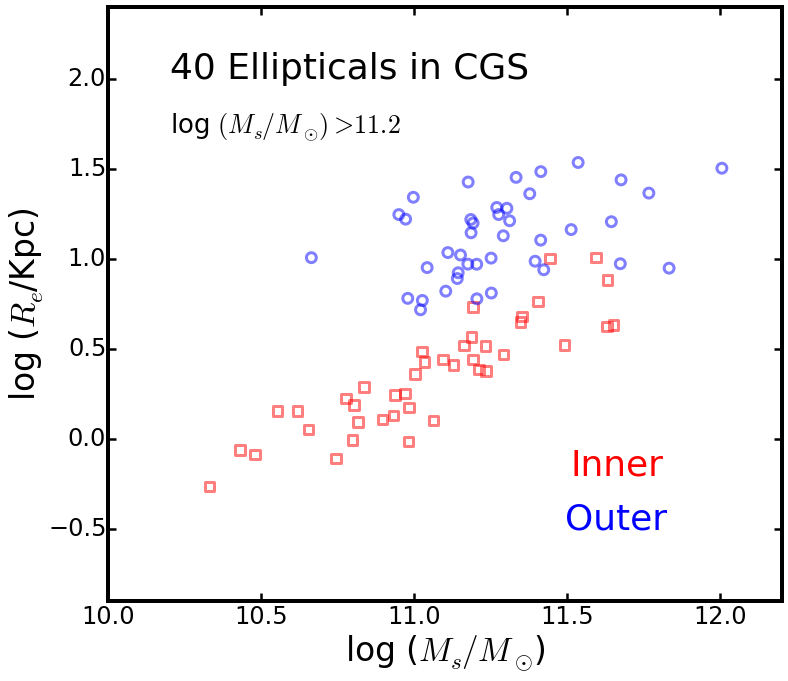

In [609]:
fig = plt.figure(figsize=(11.0, 11.0))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

#ax1.plot([-25.9,-10.1], [-25.9, -10.1], 'k--', alpha=0.6, 
#         linewidth=3.5)

""" CGS """

ax1.scatter(cgsMass['logm_inner']+0.15, np.log10(cgsMass['re_inner']),
            s=90, color='r', linewidth=3.0, marker='s',
            facecolor='none', alpha=0.5)

ax1.scatter(cgsMass['logm_outer']+0.15, np.log10(cgsMass['re_outer']), 
            s=98, color='b', linewidth=3.0, marker='o',
            facecolor='none', alpha=0.5)

ax1.set_xlabel('log ($M_{s}/M_{\odot}$)', size=33)
ax1.set_ylabel('log ($R_{e}$/Kpc)', size=33)

ax1.set_xlim(10.0, 12.2)
ax1.set_ylim(-0.9, 2.4)

#cbar = fig.colorbar(sca)
#cbar.set_label('Sersic Index', size=20)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)
    
ax1.text(10.2, 2.0, '40 Ellipticals in CGS', size=36)
ax1.text(10.2, 1.7, 'log $(M_{s}/M_{\odot})>11.2$', size=26)

ax1.text(11.52, -0.2, 'Inner', color='r', size=36)
ax1.text(11.5, -0.5, 'Outer', color='b', size=36)
    
ax1.spines['top'].set_linewidth(4.0)
ax1.spines['right'].set_linewidth(4.0)
ax1.spines['bottom'].set_linewidth(4.0)
ax1.spines['left'].set_linewidth(4.0)

# Test using z1

In [26]:
loc = 'z2'
zp = 27.0

amag_sun_g = 5.33
amag_sun_r = 4.67
amag_sun_i = 4.48
amag_sun_z = 4.42

1237679253597913345


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


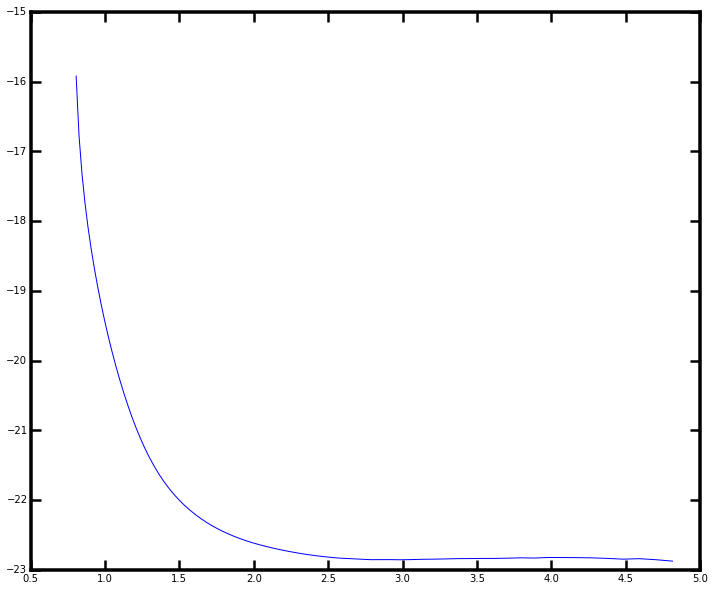

In [27]:
catFile = 'hsc_xmm_log11.6_' + loc + '.fits' 
catData = fits.open(catFile)[1].data

gal_id = catData['objid_dr12']
gal_z  = catData['z']
gal_ai = catData['extinction_i']
gal_amagi = catData['cModelAbsMag_i']
gal_logm = catData['logMass']

ii = 2

ellProf = getEllipProfile(gal_id[ii], loc, stage='3')
sma_kpc, asbp_i, amag_i = correctProf(ellProf, gal_z[ii], extinction=gal_ai[ii], 
                                      zp=27.0, amag_sun=amag_sun_i, corCurve=True)
print gal_id[ii]

plot(sma_kpc**0.25, amag_i)

In [29]:
catData.columns

ColDefs(
    name = 'objid_dr12'; format = 'K'; null = -9223372036854775808
    name = 'specobjid_dr12'; format = 'K'; null = -9223372036854775808
    name = 'bestobjid'; format = 'K'; null = -9223372036854775808
    name = 'fluxobjid'; format = 'K'; null = -9223372036854775808
    name = 'plateid'; format = 'K'; null = -9223372036854775808
    name = 'firstRelease'; format = '32A'
    name = 'plate'; format = 'I'; null = -32768
    name = 'mjd'; format = 'J'; null = -2147483648
    name = 'fiberid'; format = 'I'; null = -32768
    name = 'ra_fib'; format = 'D'
    name = 'dec_fib'; format = 'D'
    name = 'ra_pho'; format = 'D'
    name = 'dec_pho'; format = 'D'
    name = 'raerr'; format = 'D'
    name = 'decerr'; format = 'D'
    name = 'z'; format = 'E'
    name = 'zerr'; format = 'E'
    name = 'vdisp_sdss'; format = 'E'
    name = 'vdisperr_sdss'; format = 'E'
    name = 'nchild'; format = 'I'; null = -32768
    name = 'photo_type'; format = 'I'; null = -32768
    name = 'extinct

In [123]:
ellProf

<Table masked=False length=76>
   sma        intens       int_err    ...   rad_outer      mag_tot   
 float64     float64       float64    ...    float64       float64   
--------- -------------- ------------ ... ------------- -------------
      0.0  45.5986121708          nan ... 183.933787056 18.2148556008
0.5498202  42.3970521708    0.2931644 ... 183.933787056 18.2148556008
0.6048022  42.0848821707    0.3209774 ... 183.933787056 18.2148556008
0.6652824  41.7431221707    0.3512357 ... 183.933787056 18.2148556008
0.7318107  41.3692721708    0.3841477 ... 183.933787056 18.2148556008
0.8049918  40.9604521708    0.4199227 ... 183.933787056 18.2148556008
 0.885491  40.5137421707    0.4587579 ... 183.933787056 18.2148556008
0.9740401  40.0259421707    0.5008539 ... 183.933787056 18.2148556008
 1.071444  39.4539521708    0.5448861 ... 183.933787056 18.2148556008
 1.178589  38.7206021707     0.588872 ... 183.933787056 18.2148556008
      ...            ...          ... ...           ...           ...
 269.6161 -0.00229407225 0.0009707853 ... 183.933787056 18.2148556008
 296.5777  0.00170286175  0.001222235 ... 183.933787056 18.2148556008
 326.2354   -8.35725e-06 0.0009984201 ... 183.933787056 18.2148556008
  358.859 -0.00187442325 0.0005985932 ... 183.933787056 18.2148556008
 394.7449 -0.00084903525 0.0006861875 ... 183.933787056 18.2148556008
 434.2194 -0.00013574325 0.0008375644 ... 183.933787056 18.2148556008
 477.6413  0.00185173875 0.0008567441 ... 183.933787056 18.2148556008
 525.4055 -0.00012744425 0.0007806092 ... 183.933787056 18.2148556008
  577.946  0.00315543675  0.001597466 ... 183.933787056 18.2148556008
 635.7407 -0.00031134625  0.001222764 ... 183.933787056 18.2148556008

# 1 pixel(s) =  0.764 Kpc
0.934972199355
0.0


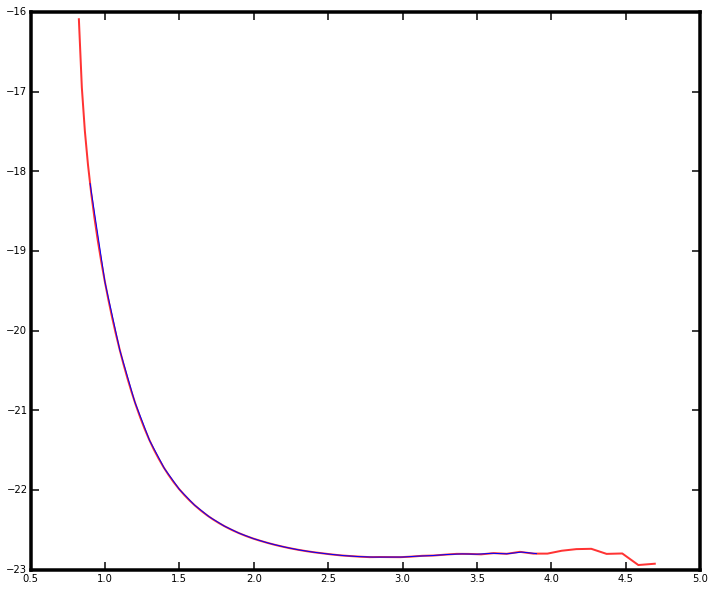

In [217]:
index = np.isfinite(amag_i)
intrpFunc = interp1d(sma_kpc[index]**0.25, amag_i[index], kind='linear')

sma_common = np.arange(0.9, 4.0, 0.1)

sbp_intrp = intrpFunc(sma_common)

plot(sma_kpc**0.25, amag_i, 'r', linewidth=2.0, alpha=0.8)
plot(sma_common, sbp_intrp)

print pixKpc(gal_z[ii])**0.25
print np.min(sma_kpc**0.25)

temp = intrpFunc(1.5)